**Installing dependencies**

In [ ]:
%pip install socceraction==1.1.1

     |████████████████████████████████| 75 kB 1.9 MB/s 
     |████████████████████████████████| 186 kB 16.0 MB/s 
     |████████████████████████████████| 235 kB 38.7 MB/s 
     |████████████████████████████████| 161 kB 34.8 MB/s 


In [ ]:
%pip install scipy==1.7.1

     |████████████████████████████████| 28.5 MB 2.6 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
from glob import glob
from sklearn.preprocessing import OneHotEncoder
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl
import socceraction.xthreat as xthreat
import socceraction.vaep as vaep
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import sklearn
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Get match ids**

In [ ]:
competitions = pd.read_json("./drive/MyDrive/master/open-data/data/competitions.json")
competitions = competitions.loc[~competitions['country_name'].isin(["Europe", "International"])]
competitions_f = competitions.loc[competitions['competition_gender'] == "female"]
competitions_m = competitions.loc[competitions['competition_gender'] == "male"]

In [ ]:
competition_ids = set(competitions.competition_id)
competition_f_ids = set(competitions_f.competition_id)
competition_m_ids = set(competitions_m.competition_id)

In [ ]:
matches_f = None
for c_id in competition_f_ids:
    for matches_json in glob("./drive/MyDrive/master/open-data/data/matches/" + str(c_id) + "/*.json"):
        if matches_f is None:
            matches_f = pd.read_json(matches_json)
        else:
            new_matches = pd.read_json(matches_json)
            matches_f = pd.concat([matches_f, new_matches], ignore_index=True)

matches_m = None
for c_id in competition_m_ids:
    for matches_json in glob("./drive/MyDrive/master/open-data/data/matches/" + str(c_id) + "/*.json"):
        if matches_m is None:
            matches_m = pd.read_json(matches_json)
        else:
            new_matches = pd.read_json(matches_json)
            matches_m = pd.concat([matches_m, new_matches], ignore_index=True)

match_ids_f = matches_f.match_id
match_ids_m = matches_m.match_id

**Convert to SPADL**

In [ ]:
loader = StatsBombLoader("./drive/MyDrive/master/open-data/data", "local")

In [ ]:
def transformer(matches, match_ids, loader):
    actions = []
    actiontypes = spadl.actiontypes_df()
    actiontypes_dict = actiontypes.to_dict()['type_name']
    for m_id in match_ids:
        match_events = loader.events(game_id=m_id)
        home_team_id = matches[matches["match_id"] == m_id]["home_team"].iloc[0]["home_team_id"]
        match_actions = spadl.statsbomb.convert_to_actions(match_events, home_team_id)
        match_actions["type_name"] = match_actions["type_id"].map(actiontypes_dict)
        time_spent = [0]
        for i in range(1, len(match_actions)):
            time_spent.append(match_actions.iloc[i]['time_seconds'] - match_actions.iloc[i - 1]['time_seconds'])
        match_actions['time_spent'] = time_spent
        actions.append(match_actions)
    actions_dataframe = pd.concat(actions)
    props_list = ["start_x", "start_y", "end_x", "end_y", "type_name", "result_id", "bodypart_id"]
    props_list.append("time_spent")
    X = actions_dataframe[props_list].copy()
    return X



**Split**

In [ ]:
ids_f_train, ids_f_test = train_test_split(match_ids_f, test_size=0.2, random_state=1)
ids_f_train, ids_f_val = train_test_split(match_ids_f, test_size=0.25, random_state=1)

ids_m_train, ids_m_test = train_test_split(match_ids_m, test_size=0.2, random_state=1)
ids_m_train, ids_m_val = train_test_split(match_ids_m, test_size=0.25, random_state=1)

In [ ]:
X_f_train = transformer(matches_f, ids_f_train, loader)


In [ ]:
X_f_test = transformer(matches_f, ids_f_test, loader)

In [ ]:
X_f_val = transformer(matches_f, ids_f_val, loader)

In [ ]:
X_m_train = transformer(matches_m, ids_m_train, loader)

In [ ]:
X_m_test = transformer(matches_m, ids_m_test, loader)

In [ ]:
X_m_val = transformer(matches_m, ids_m_val, loader)

In [ ]:
X_f_train.to_csv('./drive/MyDrive/master/dumps/X_f_train.csv', index=False)
X_f_test.to_csv('./drive/MyDrive/master/dumps/X_f_test.csv', index=False)
X_f_val.to_csv('./drive/MyDrive/master/dumps/X_f_val.csv', index=False)
X_m_train.to_csv('./drive/MyDrive/master/dumps/X_m_train.csv', index=False)
X_m_test.to_csv('./drive/MyDrive/master/dumps/X_m_test.csv', index=False)
X_m_val.to_csv('./drive/MyDrive/master/dumps/X_m_val.csv', index=False)


In [ ]:
X_f_train = pd.read_csv('./drive/MyDrive/master/dumps/X_f_train.csv')
X_f_test = pd.read_csv('./drive/MyDrive/master/dumps/X_f_test.csv')
X_f_val = pd.read_csv('./drive/MyDrive/master/dumps/X_f_val.csv')
X_m_train = pd.read_csv('./drive/MyDrive/master/dumps/X_m_train.csv')
X_m_test = pd.read_csv('./drive/MyDrive/master/dumps/X_m_test.csv')
X_m_val = pd.read_csv('./drive/MyDrive/master/dumps/X_m_val.csv')

In [ ]:
X_f_train.shape[0]

523142

In [ ]:
X_f_train[X_f_train["type_name"] == "pass"][X_f_train["result_id"] == 1].shape[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


162594

In [ ]:
X_f_test.shape[0]

138288

In [ ]:
X_f_test[X_f_test["type_name"] == "pass"][X_f_test["result_id"] == 1].shape[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


42320

In [ ]:
X_f_val.shape[0]

171546

In [ ]:
X_f_val[X_f_val["type_name"] == "pass"][X_f_val["result_id"] == 1].shape[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


52641

In [ ]:
X_m_train.shape[0]

914148

In [ ]:
X_m_train[X_m_train["type_name"] == "pass"].shape[0]

387044

In [ ]:
X_m_test.shape[0]

246435

In [ ]:
X_m_test[X_m_test["type_name"] == "pass"][X_m_test["result_id"] == 1].shape[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


87476

In [ ]:
X_m_val.shape[0]

305432

In [ ]:
X_m_val[X_m_val["type_name"] == "pass"].shape[0]

129326

**Get Y depending on n actions before goal**

In [ ]:
def get_y(matches, match_ids, n):
    scores = []
    concedes = []
    actiontypes = spadl.actiontypes_df()
    actiontypes_dict = actiontypes.to_dict()['type_name']
    for m_id in match_ids:
        match_events = loader.events(game_id=m_id)
        home_team_id = matches[matches["match_id"] == m_id]["home_team"].iloc[0]["home_team_id"]
        match_actions = spadl.statsbomb.convert_to_actions(match_events, home_team_id)
        match_actions["type_name"] = match_actions["type_id"].map(actiontypes_dict)
        match_scores = vaep.labels.scores(match_actions, nr_actions=n)
        match_concedes = vaep.labels.concedes(match_actions, nr_actions=n)
        scores.append(match_scores)
        concedes.append(match_concedes)
    scores_dataframe = pd.concat(scores)
    concedes_dataframe = pd.concat(concedes)
    return (scores_dataframe, concedes_dataframe)



In [ ]:
for n in range(5, 13):
    y_score_f_train, y_concede_f_train = get_y(matches_f, ids_f_train, n)
    y_score_f_test, y_concede_f_test = get_y(matches_f, ids_f_test, n)
    y_score_f_val, y_concede_f_val = get_y(matches_f, ids_f_val, n)
    y_score_m_train, y_concede_m_train = get_y(matches_m, ids_m_train, n)
    y_score_m_test, y_concede_m_test = get_y(matches_m, ids_m_test, n)
    y_score_m_val, y_concede_m_val = get_y(matches_m, ids_m_val, n)

    y_score_f_train.to_csv('./drive/MyDrive/master/dumps/y_score_f_train_' + str(n) + '.csv', index=False)
    y_concede_f_train.to_csv('./drive/MyDrive/master/dumps/y_concede_f_train_' + str(n) + '.csv', index=False)
    y_score_f_test.to_csv('./drive/MyDrive/master/dumps/y_score_f_test_' + str(n) + '.csv', index=False)
    y_concede_f_test.to_csv('./drive/MyDrive/master/dumps/y_concede_f_test_' + str(n) + '.csv', index=False)
    y_score_f_val.to_csv('./drive/MyDrive/master/dumps/y_score_f_val_' + str(n) + '.csv', index=False)
    y_concede_f_val.to_csv('./drive/MyDrive/master/dumps/y_concede_f_val_' + str(n) + '.csv', index=False)
    y_score_m_train.to_csv('./drive/MyDrive/master/dumps/y_score_m_train_' + str(n) + '.csv', index=False)
    y_concede_m_train.to_csv('./drive/MyDrive/master/dumps/y_concede_m_train_' + str(n) + '.csv', index=False)
    y_score_m_test.to_csv('./drive/MyDrive/master/dumps/y_score_m_test_' + str(n) + '.csv', index=False)
    y_concede_m_test.to_csv('./drive/MyDrive/master/dumps/y_concede_m_test_' + str(n) + '.csv', index=False)
    y_score_m_val.to_csv('./drive/MyDrive/master/dumps/y_score_m_val_' + str(n) + '.csv', index=False)
    y_concede_m_val.to_csv('./drive/MyDrive/master/dumps/y_concede_m_val_' + str(n) + '.csv', index=False)

**Common train dataset**

In [ ]:
X = pd.concat([X_m_train, X_f_train, X_m_test, X_f_test, X_m_val, X_f_val])

In [ ]:
X["type_name"].value_counts()

pass                962274
dribble             946431
throw_in             50201
clearance            49908
take_on              45405
tackle               43727
bad_touch            30824
foul                 30560
shot                 25636
interception         22557
cross                21068
goalkick             17281
freekick_short       16002
freekick_crossed     12901
corner_crossed        7558
keeper_save           6876
keeper_claim          3802
corner_short          2895
shot_freekick         1590
keeper_punch          1173
shot_penalty           322
Name: type_name, dtype: int64

In [ ]:
X_train = pd.concat([X_f_train, X_m_train])

In [ ]:
time_spent_categories = pd.qcut(X_train["time_spent"], 10, duplicates='drop')

In [ ]:
time_intervals = time_spent_categories.explode().unique()

In [ ]:
time_intervals = sorted(time_intervals)

In [ ]:
time_intervals

[Interval(-3270.001, 0.0, closed='right'),
 Interval(0.0, 1.0, closed='right'),
 Interval(1.0, 2.0, closed='right'),
 Interval(2.0, 3.0, closed='right'),
 Interval(3.0, 4.0, closed='right'),
 Interval(4.0, 637.0, closed='right')]

In [ ]:
def classify_time(X):
    criteria = [
        X["time_spent"] <= time_intervals[0].right,
        X["time_spent"].between(time_intervals[1].left + .000001, time_intervals[1].right),
        X["time_spent"].between(time_intervals[2].left + .000001, time_intervals[2].right),
        X["time_spent"].between(time_intervals[3].left + .000001, time_intervals[3].right),
        X["time_spent"].between(time_intervals[4].left + .000001, time_intervals[4].right),
        X["time_spent"] > time_intervals[5].left + .000001
    ]
    values = [1, 2, 3, 4, 5, 6]
    time_interval = np.select(criteria, values)
    return time_interval

In [ ]:
X_train['time_interval'] = classify_time(X_train)

In [ ]:
# encoder = OneHotEncoder()
# encoder.fit(X_train[["type_name", "result_id", "bodypart_id", "time_interval"]])
# with open('./drive/MyDrive/master/dumps/encoder.csv', "wb") as f: 
#     pickle.dump(encoder, f)

In [ ]:
encoder_file = open('./drive/MyDrive/master/dumps/encoder.csv', 'rb')
encoder = pickle.load(encoder_file) 
encoder_file.close()

In [ ]:
X_m_train['time_interval'] = classify_time(X_m_train)
X_m_train.drop("time_spent", axis=1, inplace=True)
X_m_train_enc = encoder.transform(X_m_train[["type_name", "result_id", "bodypart_id", "time_interval"]])
X_m_train_final = X_m_train.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(X_m_train_enc)).to_numpy()

In [ ]:
n_x = X_m_train_final.shape[1]

**Neural Network**

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_x):
        super(NeuralNetwork, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(n_x, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


**Train model**

In [ ]:
criterion = torch.nn.BCELoss()

Learning. n = 5
epoch: 500 , loss= 0.05545318126678467
epoch: 1000 , loss= 0.05479312688112259
epoch: 1500 , loss= 0.05419360473752022
epoch: 2000 , loss= 0.053561680018901825
epoch: 2500 , loss= 0.05287698656320572
epoch: 3000 , loss= 0.05216982215642929
epoch: 3500 , loss= 0.05149304121732712


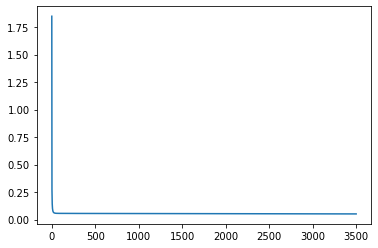

epoch: 500 , loss= 0.010556463152170181
epoch: 1000 , loss= 0.010418955236673355
epoch: 1500 , loss= 0.01036449521780014
epoch: 2000 , loss= 0.01032208651304245
epoch: 2500 , loss= 0.0102879349142313
epoch: 3000 , loss= 0.010257096961140633
epoch: 3500 , loss= 0.010228528641164303


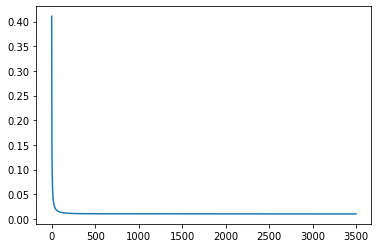

Learning. n = 6
epoch: 500 , loss= 0.059052348136901855
epoch: 1000 , loss= 0.05799339711666107
epoch: 1500 , loss= 0.05714740604162216
epoch: 2000 , loss= 0.05640147998929024
epoch: 2500 , loss= 0.0557003989815712
epoch: 3000 , loss= 0.05501669645309448
epoch: 3500 , loss= 0.054358676075935364


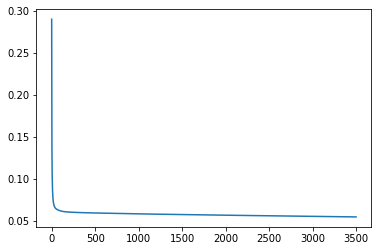

epoch: 500 , loss= 0.012756478041410446
epoch: 1000 , loss= 0.012624953873455524
epoch: 1500 , loss= 0.01255402434617281
epoch: 2000 , loss= 0.012494300492107868
epoch: 2500 , loss= 0.012440033257007599
epoch: 3000 , loss= 0.012387913651764393
epoch: 3500 , loss= 0.012335170060396194


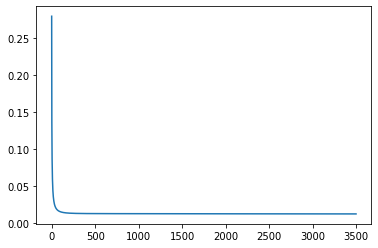

Learning. n = 7
epoch: 500 , loss= 0.07161940634250641
epoch: 1000 , loss= 0.07010776549577713
epoch: 1500 , loss= 0.06895753741264343
epoch: 2000 , loss= 0.06793045252561569
epoch: 2500 , loss= 0.06695296615362167
epoch: 3000 , loss= 0.0659988522529602
epoch: 3500 , loss= 0.06506466120481491


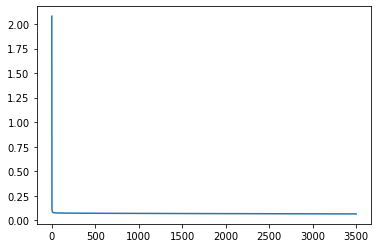

epoch: 500 , loss= 0.01687667891383171
epoch: 1000 , loss= 0.015944786369800568
epoch: 1500 , loss= 0.0155711704865098
epoch: 2000 , loss= 0.01537247747182846
epoch: 2500 , loss= 0.015243285335600376
epoch: 3000 , loss= 0.01514536701142788
epoch: 3500 , loss= 0.015063103288412094


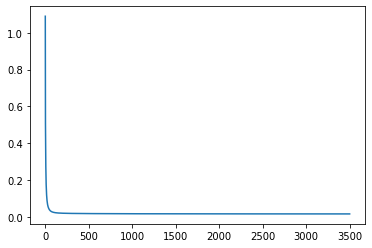

Learning. n = 8
epoch: 500 , loss= 0.0732002779841423
epoch: 1000 , loss= 0.07218087464570999
epoch: 1500 , loss= 0.07111130654811859
epoch: 2000 , loss= 0.07003437727689743
epoch: 2500 , loss= 0.06917110830545425
epoch: 3000 , loss= 0.06839844584465027
epoch: 3500 , loss= 0.0676591545343399


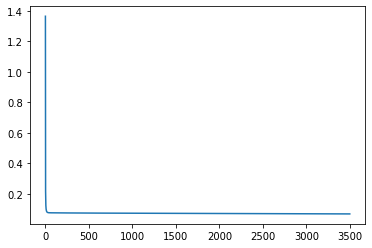

epoch: 500 , loss= 0.017468875274062157
epoch: 1000 , loss= 0.017025882378220558
epoch: 1500 , loss= 0.016809623688459396
epoch: 2000 , loss= 0.016676202416419983
epoch: 2500 , loss= 0.016570648178458214
epoch: 3000 , loss= 0.016484126448631287
epoch: 3500 , loss= 0.01640898548066616


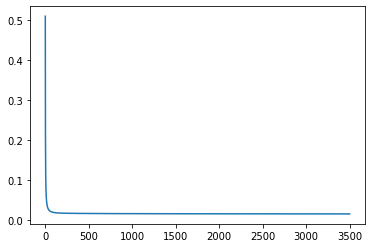

Learning. n = 9
epoch: 500 , loss= 0.08175892382860184
epoch: 1000 , loss= 0.080449678003788
epoch: 1500 , loss= 0.07934415340423584
epoch: 2000 , loss= 0.07834021002054214
epoch: 2500 , loss= 0.07735619693994522
epoch: 3000 , loss= 0.07609925419092178
epoch: 3500 , loss= 0.07520145922899246


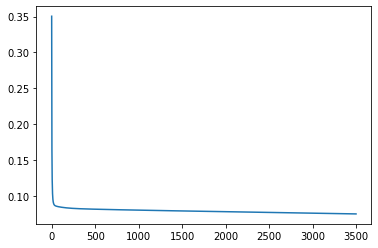

epoch: 500 , loss= 0.02071128971874714
epoch: 1000 , loss= 0.0204823836684227
epoch: 1500 , loss= 0.020317748188972473
epoch: 2000 , loss= 0.020187225192785263
epoch: 2500 , loss= 0.020077478140592575
epoch: 3000 , loss= 0.019989386200904846
epoch: 3500 , loss= 0.019909586757421494


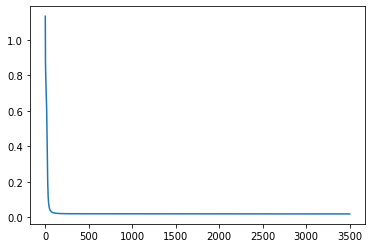

Learning. n = 10
epoch: 500 , loss= 0.08788936585187912
epoch: 1000 , loss= 0.0860690101981163
epoch: 1500 , loss= 0.08454324305057526
epoch: 2000 , loss= 0.08345449715852737
epoch: 2500 , loss= 0.0823960155248642
epoch: 3000 , loss= 0.08135755360126495
epoch: 3500 , loss= 0.0803394764661789


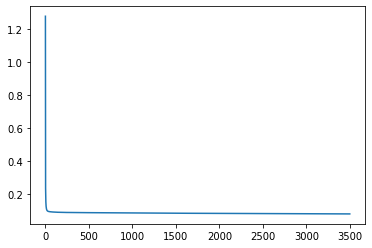

epoch: 500 , loss= 0.022832300513982773
epoch: 1000 , loss= 0.022595331072807312
epoch: 1500 , loss= 0.022429030388593674
epoch: 2000 , loss= 0.022297440096735954
epoch: 2500 , loss= 0.02218491956591606
epoch: 3000 , loss= 0.02208573743700981
epoch: 3500 , loss= 0.021998682990670204


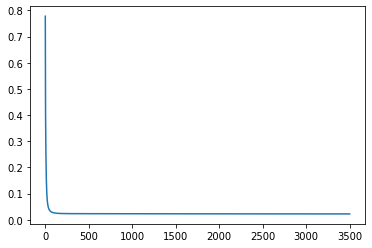

Learning. n = 11
epoch: 500 , loss= 0.09628625959157944
epoch: 1000 , loss= 0.09451527893543243
epoch: 1500 , loss= 0.09311352670192719
epoch: 2000 , loss= 0.09190232306718826
epoch: 2500 , loss= 0.0908002257347107
epoch: 3000 , loss= 0.08976719528436661
epoch: 3500 , loss= 0.08879991620779037


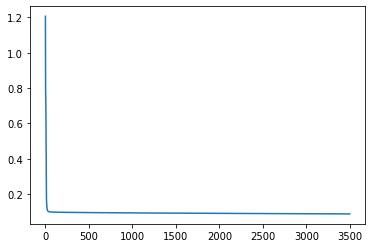

epoch: 500 , loss= 0.026267115026712418
epoch: 1000 , loss= 0.025529224425554276
epoch: 1500 , loss= 0.02515942044556141
epoch: 2000 , loss= 0.024915006011724472
epoch: 2500 , loss= 0.024712301790714264
epoch: 3000 , loss= 0.024550430476665497
epoch: 3500 , loss= 0.02442164719104767


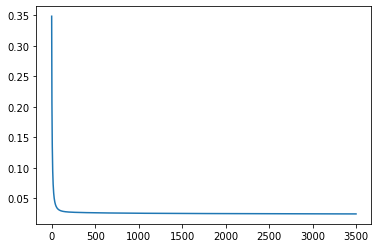

Learning. n = 12
epoch: 500 , loss= 0.0972633957862854
epoch: 1000 , loss= 0.09575723856687546
epoch: 1500 , loss= 0.09424982219934464
epoch: 2000 , loss= 0.09276256710290909
epoch: 2500 , loss= 0.09101343154907227
epoch: 3000 , loss= 0.0893099382519722
epoch: 3500 , loss= 0.08807547390460968


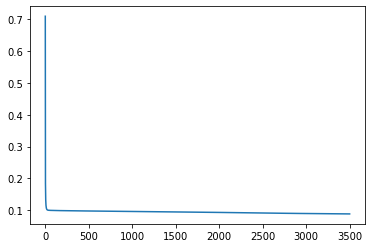

epoch: 500 , loss= 0.0301780104637146
epoch: 1000 , loss= 0.029880136251449585
epoch: 1500 , loss= 0.029660746455192566
epoch: 2000 , loss= 0.029468610882759094
epoch: 2500 , loss= 0.029280418530106544
epoch: 3000 , loss= 0.02904297411441803
epoch: 3500 , loss= 0.02876834012567997


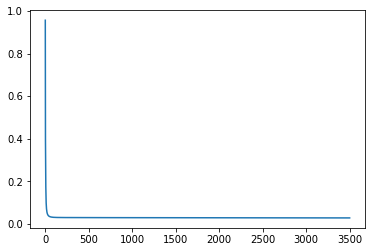

In [ ]:
for n in range(5, 13):
    y_m_score_train = pd.read_csv('./drive/MyDrive/master/dumps/y_score_m_train_' + str(n) + '.csv')
    y_m_concede_train = pd.read_csv('./drive/MyDrive/master/dumps/y_concede_m_train_' + str(n) + '.csv')

    y_score_train = y_m_score_train.astype(int).to_numpy()
    y_concede_train = y_m_concede_train.astype(int).to_numpy()

    x_torch = torch.from_numpy(X_m_train_final).type(torch.FloatTensor).to(device)
    y_torch = torch.from_numpy(y_score_train).type(torch.FloatTensor).reshape(-1, 1).to(device)

    model = NeuralNetwork(n_x).to(device)
    optimizer=torch.optim.SGD(model.parameters(),lr=0.01)

    number_of_epochs=3500
    all_loss = []
    print("Learning. n =", n)
    for epoch in range(number_of_epochs):
        y_prediction=model(x_torch)
        loss=criterion(y_prediction,y_torch)
        loss.backward()
        all_loss.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()
        if (epoch+1)%500 == 0:
            print('epoch:', epoch+1, ', loss=',loss.item())

    plt.figure()
    plt.plot(all_loss)
    plt.show()

    model_save_name = 'score_model_y_m' + str(n) + '.pt'
    path = F"./drive/MyDrive/master/models/{model_save_name}"
    torch.save(model.state_dict(), path)


    x_torch = torch.from_numpy(X_m_train_final).type(torch.FloatTensor).to(device)
    y_torch = torch.from_numpy(y_concede_train).type(torch.FloatTensor).reshape(-1, 1).to(device)

    model = NeuralNetwork(n_x).to(device)
    optimizer=torch.optim.SGD(model.parameters(),lr=0.0075)


    all_loss = []
    for epoch in range(number_of_epochs):
        y_prediction=model(x_torch)
        loss=criterion(y_prediction,y_torch)
        loss.backward()
        all_loss.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()
        if (epoch+1)%500 == 0:
            print('epoch:', epoch+1, ', loss=',loss.item())

    plt.figure()
    plt.plot(all_loss)
    plt.show()

    model_save_name = 'concede_model_y_m' + str(n) + '.pt'
    path = F"./drive/MyDrive/master/models/{model_save_name}"
    torch.save(model.state_dict(), path)


**Improve validation**

In [ ]:
n_x = 40
model = NeuralNetwork(n_x).to(device)


for n in range(5, 13):

    t = 0
    t_n = 0
    c = 0
    murder_by_numbers = 0

    model_load_name = 'score_model_y_m' + str(n) + '.pt'
    path = F"./drive/MyDrive/master/models/{model_load_name}"
    model.load_state_dict(torch.load(path))

    for match_id in ids_m_val:
        match = matches_m[matches_m["match_id"] == match_id]
        home_score = match.iloc[0]["home_score"]
        away_score = match.iloc[0]["away_score"]
        if home_score != away_score:
            c += 1
            home_team_id = match["home_team"].iloc[0]["home_team_id"]
            away_team_id = match["away_team"].iloc[0]["away_team_id"]
            match_to_rate = transformer(matches_m, [match_id], loader)
            match_to_rate['time_interval'] = classify_time(match_to_rate)
            match_to_rate.drop("time_spent", axis=1, inplace=True)
            match_to_rate_enc = encoder.transform(match_to_rate[["type_name", "result_id", "bodypart_id", "time_interval"]])
            match_to_rate = match_to_rate.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(match_to_rate_enc)).to_numpy()
            df_teams = loader.teams(match_id)
            df_players = loader.players(match_id)
            df_events = loader.events(match_id)
            df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)
            df_actions = (
                spadl.add_names(df_actions)
                .merge(loader.teams(game_id=match_id))
                .merge(loader.players(game_id=match_id))
            )
            df_actions = df_actions.sort_values(by=['action_id'])
            team_ids = df_actions["team_id"]
            match_to_rate_torch = torch.from_numpy(match_to_rate).type(torch.FloatTensor).to(device)
            with torch.no_grad():
                match_to_rate_pred=model(match_to_rate_torch).flatten()
            match_to_rate_pred = match_to_rate_pred.cpu().numpy()
            df_actions["rating"] = match_to_rate_pred
            team_ratings = df_actions[["team_id", "rating"]].groupby("team_id").agg('mean')
            team_non_shot_ratings = df_actions[df_actions["type_id"] != 11][["team_id", "rating"]].groupby("team_id").agg('mean')
            if ((home_score > away_score) and (team_ratings["rating"][home_team_id] > team_ratings["rating"][away_team_id])) or ((home_score < away_score) and (team_ratings["rating"][home_team_id] < team_ratings["rating"][away_team_id])):
                t += 1
            if ((home_score > away_score) and (team_non_shot_ratings["rating"][home_team_id] > team_non_shot_ratings["rating"][away_team_id])) or ((home_score < away_score) and (team_non_shot_ratings["rating"][home_team_id] < team_non_shot_ratings["rating"][away_team_id])):
                t_n += 1
    print('n = ', str(n))
    print('true values =', str(t))
    print('true non shot values =', str(t_n))
    print('all scores = ', str(c))

n =  5
true values = 38
true non shot values = 37
all scores =  117
victory by number of actions = 101
n =  6
true values = 48
true non shot values = 49
all scores =  117
victory by number of actions = 101
n =  7
true values = 43
true non shot values = 43
all scores =  117
victory by number of actions = 101
n =  8
true values = 50
true non shot values = 51
all scores =  117
victory by number of actions = 101
n =  9
true values = 47
true non shot values = 48
all scores =  117
victory by number of actions = 101
n =  10
true values = 46
true non shot values = 48
all scores =  117
victory by number of actions = 101
n =  11
true values = 46
true non shot values = 51
all scores =  117
victory by number of actions = 101
n =  12
true values = 49
true non shot values = 45
all scores =  117
victory by number of actions = 101


Learning. n = 12
epoch: 1000 , loss= 0.07369574159383774
epoch: 2000 , loss= 0.0717267170548439
epoch: 3000 , loss= 0.06995577365159988
epoch: 4000 , loss= 0.06830163300037384
epoch: 5000 , loss= 0.06674729287624359
epoch: 6000 , loss= 0.06531365215778351
epoch: 7000 , loss= 0.06400308758020401
epoch: 8000 , loss= 0.06282705813646317
epoch: 9000 , loss= 0.061795372515916824
epoch: 10000 , loss= 0.060883987694978714


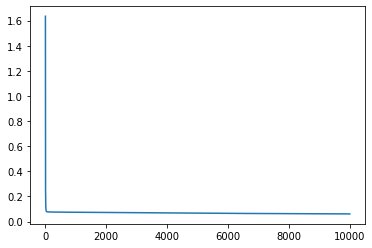

In [ ]:
y_m_score_train = pd.read_csv('./drive/MyDrive/master/dumps/y_score_m_train_8.csv')

y_score_train = y_m_score_train.astype(int).to_numpy()

x_torch = torch.from_numpy(X_m_train_final).type(torch.FloatTensor).to(device)
y_torch = torch.from_numpy(y_score_train).type(torch.FloatTensor).reshape(-1, 1).to(device)

model = NeuralNetwork(n_x).to(device)
optimizer=torch.optim.SGD(model.parameters(),lr=0.01)

number_of_epochs=10000
all_loss = []
print("Learning. n = 8")
for epoch in range(number_of_epochs):
    y_prediction=model(x_torch)
    loss=criterion(y_prediction,y_torch)
    loss.backward()
    all_loss.append(loss.item())
    optimizer.step()
    optimizer.zero_grad()
    if (epoch+1)%1000 == 0:
        print('epoch:', epoch+1, ', loss=',loss.item())

plt.figure()
plt.plot(all_loss)
plt.show()

model_save_name = 'score_model_y_m_extended_8.pt'
path = F"./drive/MyDrive/master/models/{model_save_name}"
torch.save(model.state_dict(), path)


In [ ]:
t = 0
t_n = 0
c = 0

model_load_name = 'score_model_y_m_extended_8.pt'
path = F"./drive/MyDrive/master/models/{model_load_name}"
model.load_state_dict(torch.load(path))

for match_id in ids_m_val:
    match = matches_m[matches_m["match_id"] == match_id]
    home_score = match.iloc[0]["home_score"]
    away_score = match.iloc[0]["away_score"]
    if home_score != away_score:
        c += 1
        home_team_id = match["home_team"].iloc[0]["home_team_id"]
        away_team_id = match["away_team"].iloc[0]["away_team_id"]
        match_to_rate = transformer(matches_m, [match_id], loader)
        match_to_rate['time_interval'] = classify_time(match_to_rate)
        match_to_rate.drop("time_spent", axis=1, inplace=True)
        match_to_rate_enc = encoder.transform(match_to_rate[["type_name", "result_id", "bodypart_id", "time_interval"]])
        match_to_rate = match_to_rate.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(match_to_rate_enc)).to_numpy()
        df_teams = loader.teams(match_id)
        df_players = loader.players(match_id)
        df_events = loader.events(match_id)
        df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)
        df_actions = (
            spadl.add_names(df_actions)
            .merge(loader.teams(game_id=match_id))
            .merge(loader.players(game_id=match_id))
        )
        df_actions = df_actions.sort_values(by=['action_id'])
        team_ids = df_actions["team_id"]
        match_to_rate_torch = torch.from_numpy(match_to_rate).type(torch.FloatTensor).to(device)
        with torch.no_grad():
            match_to_rate_pred=model(match_to_rate_torch).flatten()
        match_to_rate_pred = match_to_rate_pred.cpu().numpy()
        df_actions["rating"] = match_to_rate_pred
        team_ratings = df_actions[["team_id", "rating"]].groupby("team_id").agg('mean')
        team_non_shot_ratings = df_actions[df_actions["type_id"] != 11][["team_id", "rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_ratings["rating"][home_team_id] > team_ratings["rating"][away_team_id])) or ((home_score < away_score) and (team_ratings["rating"][home_team_id] < team_ratings["rating"][away_team_id])):
            t += 1
        if ((home_score > away_score) and (team_non_shot_ratings["rating"][home_team_id] > team_non_shot_ratings["rating"][away_team_id])) or ((home_score < away_score) and (team_non_shot_ratings["rating"][home_team_id] < team_non_shot_ratings["rating"][away_team_id])):
            t_n += 1
print('true values =', str(t))
print('true non shot values =', str(t_n))
print('all scores = ', str(c))

true values = 68
true non shot values = 69
all scores =  117
victory by number of actions = 101


In [ ]:
from scipy.stats import binom_test

In [ ]:
binom_test(68, 117, .5, alternative='greater')

0.047836357504802286

In [ ]:
n_x = 40
model = NeuralNetwork(n_x).to(device)


for n in range(5, 13):

    t = 0
    t_n = 0
    c = 0

    model_load_name = 'concede_model_y_m' + str(n) + '.pt'
    path = F"./drive/MyDrive/master/models/{model_load_name}"
    model.load_state_dict(torch.load(path))

    for match_id in ids_m_val:
        match = matches_m[matches_m["match_id"] == match_id]
        home_score = match.iloc[0]["home_score"]
        away_score = match.iloc[0]["away_score"]
        if home_score != away_score:
            c += 1
            home_team_id = match["home_team"].iloc[0]["home_team_id"]
            away_team_id = match["away_team"].iloc[0]["away_team_id"]
            match_to_rate = transformer(matches_m, [match_id], loader)
            match_to_rate['time_interval'] = classify_time(match_to_rate)
            match_to_rate.drop("time_spent", axis=1, inplace=True)
            match_to_rate_enc = encoder.transform(match_to_rate[["type_name", "result_id", "bodypart_id", "time_interval"]])
            match_to_rate = match_to_rate.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(match_to_rate_enc)).to_numpy()
            df_teams = loader.teams(match_id)
            df_players = loader.players(match_id)
            df_events = loader.events(match_id)
            df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)
            df_actions = (
                spadl.add_names(df_actions)
                .merge(loader.teams(game_id=match_id))
                .merge(loader.players(game_id=match_id))
            )
            df_actions = df_actions.sort_values(by=['action_id'])
            team_ids = df_actions["team_id"]
            match_to_rate_torch = torch.from_numpy(match_to_rate).type(torch.FloatTensor).to(device)
            with torch.no_grad():
                match_to_rate_pred=model(match_to_rate_torch).flatten()
            match_to_rate_pred = match_to_rate_pred.cpu().numpy()
            df_actions["antirating"] = match_to_rate_pred
            team_antiratings = df_actions[["team_id", "antirating"]].groupby("team_id").agg('mean')
            team_non_shot_ratings = df_actions[df_actions["type_id"] != 11][["team_id", "antirating"]].groupby("team_id").agg('mean')
            if ((home_score > away_score) and (team_antiratings["antirating"][home_team_id] < team_antiratings["antirating"][away_team_id])) or ((home_score < away_score) and (team_antiratings["antirating"][home_team_id] > team_antiratings["antirating"][away_team_id])):
                t += 1
    print('n = ', str(n))
    print('true values =', str(t))
    print('true non shot values =', str(t_n))
    print('all scores =', str(c))

n =  5
true values = 78
true non shot values = 0
all scores = 117
victory by number of actions = 16
n =  6
true values = 81
true non shot values = 0
all scores = 117
victory by number of actions = 16
n =  7
true values = 77
true non shot values = 0
all scores = 117
victory by number of actions = 16
n =  8
true values = 79
true non shot values = 0
all scores = 117
victory by number of actions = 16
n =  9
true values = 80
true non shot values = 0
all scores = 117
victory by number of actions = 16
n =  10
true values = 77
true non shot values = 0
all scores = 117
victory by number of actions = 16
n =  11
true values = 79
true non shot values = 0
all scores = 117
victory by number of actions = 16
n =  12
true values = 77
true non shot values = 0
all scores = 117
victory by number of actions = 16


epoch: 1000 , loss= 0.0132046639919281
epoch: 2000 , loss= 0.012938453815877438
epoch: 3000 , loss= 0.012799362652003765
epoch: 4000 , loss= 0.012693184427917004
epoch: 5000 , loss= 0.012596839107573032
epoch: 6000 , loss= 0.012498538009822369
epoch: 7000 , loss= 0.012396145612001419
epoch: 8000 , loss= 0.012302592396736145
epoch: 9000 , loss= 0.012219760566949844
epoch: 10000 , loss= 0.012138817459344864


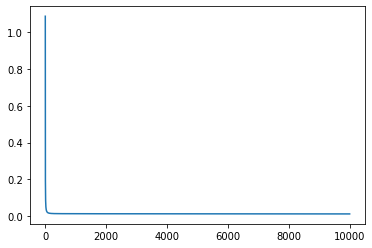

In [ ]:
y_m_concede_train = pd.read_csv('./drive/MyDrive/master/dumps/y_concede_m_train_6.csv')

y_concede_train = y_m_concede_train.astype(int).to_numpy()

x_torch = torch.from_numpy(X_m_train_final).type(torch.FloatTensor).to(device)
y_torch = torch.from_numpy(y_concede_train).type(torch.FloatTensor).reshape(-1, 1).to(device)

model = NeuralNetwork(n_x).to(device)
optimizer=torch.optim.SGD(model.parameters(),lr=0.0075)

number_of_epochs=10000
all_loss = []
for epoch in range(number_of_epochs):
    y_prediction=model(x_torch)
    loss=criterion(y_prediction,y_torch)
    loss.backward()
    all_loss.append(loss.item())
    optimizer.step()
    optimizer.zero_grad()
    if (epoch+1)%1000 == 0:
        print('epoch:', epoch+1, ', loss=',loss.item())

plt.figure()
plt.plot(all_loss)
plt.show()

model_save_name = 'concede_model_y_m_extended_6.pt'
path = F"./drive/MyDrive/master/models/{model_save_name}"
torch.save(model.state_dict(), path)


In [ ]:
n_x = 40
model = NeuralNetwork(n_x).to(device)

t = 0
t_n = 0
c = 0
murder_by_numbers = 0

model_load_name = 'concede_model_y_m_extended_6.pt'
path = F"./drive/MyDrive/master/models/{model_load_name}"
model.load_state_dict(torch.load(path))

for match_id in ids_m_val:
    match = matches_m[matches_m["match_id"] == match_id]
    home_score = match.iloc[0]["home_score"]
    away_score = match.iloc[0]["away_score"]
    if home_score != away_score:
        c += 1
        home_team_id = match["home_team"].iloc[0]["home_team_id"]
        away_team_id = match["away_team"].iloc[0]["away_team_id"]
        match_to_rate = transformer(matches_m, [match_id], loader)
        match_to_rate['time_interval'] = classify_time(match_to_rate)
        match_to_rate.drop("time_spent", axis=1, inplace=True)
        match_to_rate_enc = encoder.transform(match_to_rate[["type_name", "result_id", "bodypart_id", "time_interval"]])
        match_to_rate = match_to_rate.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(match_to_rate_enc)).to_numpy()
        df_teams = loader.teams(match_id)
        df_players = loader.players(match_id)
        df_events = loader.events(match_id)
        df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)
        df_actions = (
            spadl.add_names(df_actions)
            .merge(loader.teams(game_id=match_id))
            .merge(loader.players(game_id=match_id))
        )
        df_actions = df_actions.sort_values(by=['action_id'])
        team_ids = df_actions["team_id"]
        match_to_rate_torch = torch.from_numpy(match_to_rate).type(torch.FloatTensor).to(device)
        with torch.no_grad():
            match_to_rate_pred=model(match_to_rate_torch).flatten()
        match_to_rate_pred = match_to_rate_pred.cpu().numpy()
        df_actions["antirating"] = match_to_rate_pred
        team_antiratings = df_actions[["team_id", "antirating"]].groupby("team_id").agg('mean')
        team_non_shot_ratings = df_actions[df_actions["type_id"] != 11][["team_id", "antirating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_antiratings["antirating"][home_team_id] < team_antiratings["antirating"][away_team_id])) or ((home_score < away_score) and (team_antiratings["antirating"][home_team_id] > team_antiratings["antirating"][away_team_id])):
            t += 1
print('true values =', str(t))
print('true non shot values =', str(t_n))
print('all scores =', str(c))

n =  12
true values = 80
true non shot values = 0
all scores = 117
victory by number of actions = 16


In [ ]:
binom_test(80, 117, .5, alternative='greater')

4.3587183647132327e-05

In [ ]:
n_x = 40

score_model = NeuralNetwork(n_x).to(device)
model_load_name = 'score_model_y_m_extended_8.pt'
path = F"./drive/MyDrive/master/models/{model_load_name}"
score_model.load_state_dict(torch.load(path))

concede_model = NeuralNetwork(n_x).to(device)
model_load_name = 'concede_model_y_m6.pt'
path = F"./drive/MyDrive/master/models/{model_load_name}"
concede_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
t = 0
t_n = 0
c = 0

for match_id in ids_m_val:
    match = matches_m[matches_m["match_id"] == match_id]
    home_score = match.iloc[0]["home_score"]
    away_score = match.iloc[0]["away_score"]
    if home_score != away_score:
        c += 1
        home_team_id = match["home_team"].iloc[0]["home_team_id"]
        away_team_id = match["away_team"].iloc[0]["away_team_id"]
        match_to_rate = transformer(matches_m, [match_id], loader)
        match_to_rate['time_interval'] = classify_time(match_to_rate)
        match_to_rate.drop("time_spent", axis=1, inplace=True)
        match_to_rate_enc = encoder.transform(match_to_rate[["type_name", "result_id", "bodypart_id", "time_interval"]])
        match_to_rate = match_to_rate.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(match_to_rate_enc)).to_numpy()
        df_teams = loader.teams(match_id)
        df_players = loader.players(match_id)
        df_events = loader.events(match_id)
        df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)
        df_actions = (
            spadl.add_names(df_actions)
            .merge(loader.teams(game_id=match_id))
            .merge(loader.players(game_id=match_id))
        )
        df_actions = df_actions.sort_values(by=['action_id'])
        team_ids = df_actions["team_id"]
        match_to_rate_torch = torch.from_numpy(match_to_rate).type(torch.FloatTensor).to(device)
        with torch.no_grad():
            match_to_rate_pred_score=score_model(match_to_rate_torch).flatten()
        with torch.no_grad():
            match_to_rate_pred_concede=concede_model(match_to_rate_torch).flatten()
        match_to_rate_pred_score = match_to_rate_pred_score.cpu().numpy()
        match_to_rate_pred_concede = match_to_rate_pred_concede.cpu().numpy()
        df_actions["rating"] = match_to_rate_pred_score - match_to_rate_pred_concede
        team_ratings = df_actions[["team_id", "rating"]].groupby("team_id").agg('mean')
        team_non_shot_ratings = df_actions[df_actions["type_id"] != 11][["team_id", "rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_ratings["rating"][home_team_id] > team_ratings["rating"][away_team_id])) or ((home_score < away_score) and (team_ratings["rating"][home_team_id] < team_ratings["rating"][away_team_id])):
            t += 1
        if ((home_score > away_score) and (team_non_shot_ratings["rating"][home_team_id] > team_non_shot_ratings["rating"][away_team_id])) or ((home_score < away_score) and (team_non_shot_ratings["rating"][home_team_id] < team_non_shot_ratings["rating"][away_team_id])):
            t_n += 1
print('true values =', str(t))
print('true non shot values =', str(t_n))
print('all scores =', str(c))

true values = 81
true values in dominated games = 0
true non shot values = 78
all scores = 117


In [ ]:
binom_test(81, 117, .5, alternative='greater')

1.9331722041194814e-05

**Rating Test Dataset**

In [ ]:
avg_ratings = {
    "female_score": {},
    "female_concede": {},
    "male_score": {},
    "male_concede": {}
}

In [ ]:
male_players_with_ratings_score = {}
male_players_with_ratings_concede = {}
c = 0
t = 0
t_s = 0
t_c = 0
for match_id in ids_m_test:
    match = matches_m[matches_m["match_id"] == match_id]
    home_score = match.iloc[0]["home_score"]
    away_score = match.iloc[0]["away_score"]
    home_team_id = match["home_team"].iloc[0]["home_team_id"]
    away_team_id = match["away_team"].iloc[0]["away_team_id"]
    match_to_rate = transformer(matches_m, [match_id], loader)
    match_to_rate['time_interval'] = classify_time(match_to_rate)
    match_to_rate.drop("time_spent", axis=1, inplace=True)
    match_to_rate_enc = encoder.transform(match_to_rate[["type_name", "result_id", "bodypart_id", "time_interval"]])
    match_to_rate = match_to_rate.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(match_to_rate_enc)).to_numpy()
    df_teams = loader.teams(match_id)
    df_players = loader.players(match_id)
    df_events = loader.events(match_id)
    df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)
    df_actions = (
        spadl.add_names(df_actions)
        .merge(loader.teams(game_id=match_id))
        .merge(loader.players(game_id=match_id))
    )
    df_actions = df_actions.sort_values(by=['action_id'])
    team_ids = df_actions["team_id"]
    match_to_rate_torch = torch.from_numpy(match_to_rate).type(torch.FloatTensor).to(device)
    with torch.no_grad():
        match_to_rate_pred_score=score_model(match_to_rate_torch).flatten()
    with torch.no_grad():
        match_to_rate_pred_concede=concede_model(match_to_rate_torch).flatten()
    match_to_rate_pred_score = match_to_rate_pred_score.cpu().numpy()
    match_to_rate_pred_concede = match_to_rate_pred_concede.cpu().numpy()
    df_actions["score_rating"] = match_to_rate_pred_score
    df_actions["concede_rating"] = match_to_rate_pred_concede
    df_actions["rating"] = match_to_rate_pred_score - match_to_rate_pred_concede
    if home_score != away_score:
        c += 1
        team_score_ratings = df_actions[["team_id", "score_rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_score_ratings["score_rating"][home_team_id] > team_score_ratings["score_rating"][away_team_id])) or ((home_score < away_score) and (team_score_ratings["score_rating"][home_team_id] < team_score_ratings["score_rating"][away_team_id])):
            t_s += 1
        team_concede_ratings = df_actions[["team_id", "concede_rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_concede_ratings["concede_rating"][home_team_id] < team_concede_ratings["concede_rating"][away_team_id])) or ((home_score < away_score) and (team_concede_ratings["concede_rating"][home_team_id] > team_concede_ratings["concede_rating"][away_team_id])):
            t_c += 1
        team_ratings = df_actions[["team_id", "rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_ratings["rating"][home_team_id] > team_ratings["rating"][away_team_id])) or ((home_score < away_score) and (team_ratings["rating"][home_team_id] < team_ratings["rating"][away_team_id])):
            t += 1
    score_ratings = df_actions.groupby("player_id").aggregate({'score_rating': 'mean'})
    for i in range(len(score_ratings.index)):
        if score_ratings.index[i] not in male_players_with_ratings_score:
            male_players_with_ratings_score[score_ratings.index[i]] = [score_ratings.iloc[i][0]]
        else:
            male_players_with_ratings_score[score_ratings.index[i]].append(score_ratings.iloc[i][0])
    concede_ratings = df_actions.groupby("player_id").aggregate({'concede_rating': 'mean'})
    for i in range(len(concede_ratings.index)):
        if concede_ratings.index[i] not in male_players_with_ratings_concede:
            male_players_with_ratings_concede[concede_ratings.index[i]] = [concede_ratings.iloc[i][0]]
        else:
            male_players_with_ratings_concede[concede_ratings.index[i]].append(concede_ratings.iloc[i][0])

print('true scoring values =', str(t_s))
print('true conceding values =', str(t_c))
print('true values =', str(t))
print('all scores =', str(c))

true scoring values = 58
true conceding values = 65
true values = 66
all scores = 95


In [ ]:
binom_test(58, 95, .5, alternative='greater')

0.01980411883527295

In [ ]:
binom_test(65, 95, .5, alternative='greater')

0.000212396364447373

In [ ]:
binom_test(66, 95, .5, alternative='greater')

9.320096314589007e-05

In [ ]:
for key, value in male_players_with_ratings_score.items():
    avg_ratings["male_score"][key] = {
        "rating": np.mean(value),
        "matches": len(value)
    }

for key, value in male_players_with_ratings_concede.items():
    avg_ratings["male_concede"][key] = {
        "rating": np.mean(value),
        "matches": len(value)
    }

In [ ]:
female_players_with_ratings_score = {}
female_players_with_ratings_concede = {}
c = 0
t = 0
t_s = 0
t_c = 0

for match_id in ids_f_test:
    match = matches_f[matches_f["match_id"] == match_id]
    home_score = match.iloc[0]["home_score"]
    away_score = match.iloc[0]["away_score"]
    home_team_id = match["home_team"].iloc[0]["home_team_id"]
    away_team_id = match["away_team"].iloc[0]["away_team_id"]
    match_to_rate = transformer(matches_f, [match_id], loader)
    match_to_rate['time_interval'] = classify_time(match_to_rate)
    match_to_rate.drop("time_spent", axis=1, inplace=True)
    match_to_rate_enc = encoder.transform(match_to_rate[["type_name", "result_id", "bodypart_id", "time_interval"]])
    match_to_rate = match_to_rate.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(match_to_rate_enc)).to_numpy()
    df_teams = loader.teams(match_id)
    df_players = loader.players(match_id)
    df_events = loader.events(match_id)
    df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)
    df_actions = (
        spadl.add_names(df_actions)
        .merge(loader.teams(game_id=match_id))
        .merge(loader.players(game_id=match_id))
    )
    df_actions = df_actions.sort_values(by=['action_id'])
    team_ids = df_actions["team_id"]
    match_to_rate_torch = torch.from_numpy(match_to_rate).type(torch.FloatTensor).to(device)
    with torch.no_grad():
        match_to_rate_pred_score=score_model(match_to_rate_torch).flatten()
    with torch.no_grad():
        match_to_rate_pred_concede=concede_model(match_to_rate_torch).flatten()
    match_to_rate_pred_score = match_to_rate_pred_score.cpu().numpy()
    match_to_rate_pred_concede = match_to_rate_pred_concede.cpu().numpy()
    df_actions["score_rating"] = match_to_rate_pred_score
    df_actions["concede_rating"] = match_to_rate_pred_concede
    df_actions["rating"] = match_to_rate_pred_score - match_to_rate_pred_concede
    if home_score != away_score:
        c += 1
        team_score_ratings = df_actions[["team_id", "score_rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_score_ratings["score_rating"][home_team_id] > team_score_ratings["score_rating"][away_team_id])) or ((home_score < away_score) and (team_score_ratings["score_rating"][home_team_id] < team_score_ratings["score_rating"][away_team_id])):
            t_s += 1
        team_concede_ratings = df_actions[["team_id", "concede_rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_concede_ratings["concede_rating"][home_team_id] < team_concede_ratings["concede_rating"][away_team_id])) or ((home_score < away_score) and (team_concede_ratings["concede_rating"][home_team_id] > team_concede_ratings["concede_rating"][away_team_id])):
            t_c += 1
        team_ratings = df_actions[["team_id", "rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_ratings["rating"][home_team_id] > team_ratings["rating"][away_team_id])) or ((home_score < away_score) and (team_ratings["rating"][home_team_id] < team_ratings["rating"][away_team_id])):
            t += 1
    score_ratings = df_actions.groupby("player_id").aggregate({'score_rating': 'mean'})
    for i in range(len(score_ratings.index)):
        if score_ratings.index[i] not in female_players_with_ratings_score:
            female_players_with_ratings_score[score_ratings.index[i]] = [score_ratings.iloc[i][0]]
        else:
            female_players_with_ratings_score[score_ratings.index[i]].append(score_ratings.iloc[i][0])
    concede_ratings = df_actions.groupby("player_id").aggregate({'concede_rating': 'mean'})
    for i in range(len(concede_ratings.index)):
        if concede_ratings.index[i] not in female_players_with_ratings_concede:
            female_players_with_ratings_concede[concede_ratings.index[i]] = [concede_ratings.iloc[i][0]]
        else:
            female_players_with_ratings_concede[concede_ratings.index[i]].append(concede_ratings.iloc[i][0])

print('true scoring values =', str(t_s))
print('true conceding values =', str(t_c))
print('true values =', str(t))
print('all scores =', str(c))

true scoring values = 33
true conceding values = 29
true values = 32
all scores = 58


In [ ]:
binom_test(33, 58, .5, alternative='greater')

0.17907165090306884

In [ ]:
binom_test(29, 58, .5, alternative='greater')

0.5521583930552044

In [ ]:
binom_test(32, 58, .5, alternative='greater')

0.2559211542190845

In [ ]:
from scipy.stats import fisher_exact

In [ ]:
for key, value in female_players_with_ratings_score.items():
    avg_ratings["female_score"][key] = {
        "rating": np.mean(value),
        "matches": len(value)
    }

for key, value in female_players_with_ratings_concede.items():
    avg_ratings["female_concede"][key] = {
        "rating": np.mean(value),
        "matches": len(value)
    }

In [ ]:
np.mean([i["rating"] for i in avg_ratings["female_score"].values()])

0.014850397

In [ ]:
np.mean([i["rating"] for i in avg_ratings["male_score"].values()])

0.0147684645

In [ ]:
np.mean([i["rating"] for i in avg_ratings["female_concede"].values()])

0.003983256

In [ ]:
np.mean([i["rating"] for i in avg_ratings["male_concede"].values()])

0.0034371659

In [ ]:
female_score_ratings = [i["rating"] for i in avg_ratings["female_score"].values()]
male_score_ratings = [i["rating"] for i in avg_ratings["male_score"].values()]

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
female_concede_ratings = [i["rating"] for i in avg_ratings["female_concede"].values()]
male_concede_ratings = [i["rating"] for i in avg_ratings["male_concede"].values()]

In [ ]:
with open('./drive/MyDrive/master/dumps/avg_ratings.json', 'wb') as f:
    pickle.dump(avg_ratings, f)

**Model Check Up**

In [ ]:
ids_m_test

364      16182
247      69189
65      267520
237      69231
547      68325
        ...   
392      68313
417      70275
17     3749276
370      16136
475      69256
Name: match_id, Length: 111, dtype: int64

In [ ]:
matches_m[matches_m["match_id"] == 16182]

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,metadata,match_week,competition_stage,stadium,referee
364,16182,2019-02-16,20:45:00.000,"{'competition_id': 11, 'country_name': 'Spain'...","{'season_id': 4, 'season_name': '2018/2019'}","{'home_team_id': 217, 'home_team_name': 'Barce...","{'away_team_id': 901, 'away_team_name': 'Real ...",1,0,available,scheduled,2020-07-29T05:00,2021-06-13T16:17:31.694,"{'data_version': '1.1.0', 'shot_fidelity_versi...",24,"{'id': 1, 'name': 'Regular Season'}","{'id': 342, 'name': 'Camp Nou (Barcelona)', 'c...",NaN


In [ ]:
match_id = 16182
match = matches_m[matches_m["match_id"] == match_id]
home_team_id = match["home_team"].iloc[0]["home_team_id"]
away_team_id = match["away_team"].iloc[0]["away_team_id"]
match_to_rate = transformer(matches_m, [match_id], loader)
match_to_rate['time_interval'] = classify_time(match_to_rate)
match_to_rate.drop("time_spent", axis=1, inplace=True)
match_to_rate_enc = encoder.transform(match_to_rate[["type_name", "result_id", "bodypart_id", "time_interval"]])
match_to_rate = match_to_rate.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(match_to_rate_enc)).to_numpy()
df_teams = loader.teams(match_id)
df_players = loader.players(match_id)
df_events = loader.events(match_id)
df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)
df_actions = (
    spadl.add_names(df_actions)
    .merge(loader.teams(game_id=match_id))
    .merge(loader.players(game_id=match_id))
)
df_actions = df_actions.sort_values(by=['action_id'])
team_ids = df_actions["team_id"]
match_to_rate_torch = torch.from_numpy(match_to_rate).type(torch.FloatTensor).to(device)
with torch.no_grad():
    match_to_rate_pred_score=score_model(match_to_rate_torch).flatten()
with torch.no_grad():
    match_to_rate_pred_concede=concede_model(match_to_rate_torch).flatten()
match_to_rate_pred_score = match_to_rate_pred_score.cpu().numpy()
match_to_rate_pred_concede = match_to_rate_pred_concede.cpu().numpy()
df_actions["score_rating"] = match_to_rate_pred_score
df_actions["concede_rating"] = match_to_rate_pred_concede
df_actions["rating"] = match_to_rate_pred_score - match_to_rate_pred_concede

In [ ]:
score_ratings_barca = df_actions[df_actions["team_id"] == 217].groupby("player_name").aggregate({'score_rating': 'mean'})
score_ratings_valladolid = df_actions[df_actions["team_id"] == 901].groupby("player_name").aggregate({'score_rating': 'mean'})
concede_ratings_barca = df_actions[df_actions["team_id"] == 217].groupby("player_name").aggregate({'concede_rating': 'mean'})
concede_ratings_valladolid = df_actions[df_actions["team_id"] == 901].groupby("player_name").aggregate({'concede_rating': 'mean'})
ratings_barca = df_actions[df_actions["team_id"] == 217].groupby("player_name").aggregate({'rating': 'mean'})
ratings_valladolid = df_actions[df_actions["team_id"] == 901].groupby("player_name").aggregate({'rating': 'mean'})

In [ ]:
score_ratings_barca

,score_rating
player_name,
Arturo Erasmo Vidal Pardo,0.015643
Carles Aleña Castillo,0.011586
Gerard Piqué Bernabéu,0.029896
Ivan Rakitić,0.017384
Jordi Alba Ramos,0.004301
Kevin-Prince Boateng,0.009705
Lionel Andrés Messi Cuccittini,0.013816
Luis Alberto Suárez Díaz,0.011725
Marc-André ter Stegen,0.027018


In [ ]:
score_ratings_valladolid

,score_rating
player_name,
Antonio Jesús Regal Angulo,0.005870
Anuar Mohamed Tuhami,0.010834
Daniele Verde,0.018870
Enes Ünal,0.019937
Fernando Calero Villa,0.012161
Francisco José Olivas Alba,0.011889
Joaquín Fernández Moreno,0.005598
Jordi Masip López,0.004501
José Ignacio Martínez García,0.019662


In [ ]:
concede_ratings_barca

,concede_rating
player_name,
Arturo Erasmo Vidal Pardo,0.000506
Carles Aleña Castillo,0.000332
Gerard Piqué Bernabéu,0.007244
Ivan Rakitić,0.003201
Jordi Alba Ramos,0.000065
Kevin-Prince Boateng,0.001368
Lionel Andrés Messi Cuccittini,0.000167
Luis Alberto Suárez Díaz,0.000852
Marc-André ter Stegen,0.006026


In [ ]:
concede_ratings_valladolid

,concede_rating
player_name,
Antonio Jesús Regal Angulo,0.000096
Anuar Mohamed Tuhami,0.000898
Daniele Verde,0.005623
Enes Ünal,0.002497
Fernando Calero Villa,0.001273
Francisco José Olivas Alba,0.000067
Joaquín Fernández Moreno,0.000122
Jordi Masip López,0.000006
José Ignacio Martínez García,0.007172


In [ ]:
ratings_barca

,rating
player_name,
Arturo Erasmo Vidal Pardo,0.015137
Carles Aleña Castillo,0.011254
Gerard Piqué Bernabéu,0.022652
Ivan Rakitić,0.014182
Jordi Alba Ramos,0.004235
Kevin-Prince Boateng,0.008337
Lionel Andrés Messi Cuccittini,0.013648
Luis Alberto Suárez Díaz,0.010873
Marc-André ter Stegen,0.020992


In [ ]:
ratings_valladolid

,rating
player_name,
Antonio Jesús Regal Angulo,0.005774
Anuar Mohamed Tuhami,0.009936
Daniele Verde,0.013247
Enes Ünal,0.017440
Fernando Calero Villa,0.010888
Francisco José Olivas Alba,0.011822
Joaquín Fernández Moreno,0.005476
Jordi Masip López,0.004495
José Ignacio Martínez García,0.012490


In [ ]:
np.mean(pd.concat([ratings_barca, ratings_valladolid])["rating"])

0.011185362935066223

In [ ]:
df_actions["player_name"].value_counts()

Lionel Andrés Messi Cuccittini      203
Gerard Piqué Bernabéu               177
Carles Aleña Castillo               174
Sergi Roberto Carnicer              162
Arturo Erasmo Vidal Pardo           160
Sergio Busquets i Burgos            156
Jordi Alba Ramos                    150
Miguel Alfonso Herrero Javaloyas    146
Anuar Mohamed Tuhami                126
José Ignacio Martínez García        112
Ousmane Dembélé                     102
Fernando Calero Villa                98
Francisco José Olivas Alba           90
Sergio Guardiola Navarro             89
Thomas Vermaelen                     87
Antonio Jesús Regal Angulo           87
Joaquín Fernández Moreno             75
Jordi Masip López                    65
Daniele Verde                        65
Marc-André ter Stegen                60
Luis Alberto Suárez Díaz             50
Enes Ünal                            42
Kevin-Prince Boateng                 36
Philippe Coutinho Correia            27
Ivan Rakitić                         25


In [ ]:
actions_counts = df_actions[df_actions["team_id"] == 217]["player_name"].value_counts().to_frame()

In [ ]:
actions_counts.rename(columns={"player_name": "actions_count"}, inplace=True)

In [ ]:
actions_counts

,actions_count
Lionel Andrés Messi Cuccittini,203
Gerard Piqué Bernabéu,177
Carles Aleña Castillo,174
Sergi Roberto Carnicer,162
Arturo Erasmo Vidal Pardo,160
Sergio Busquets i Burgos,156
Jordi Alba Ramos,150
Ousmane Dembélé,102
Thomas Vermaelen,87
Marc-André ter Stegen,60


In [ ]:
ratings_actions_count = ratings_barca.merge(actions_counts, left_index=True, right_index=True)

In [ ]:
ratings_actions_count

,rating,actions_count
Arturo Erasmo Vidal Pardo,0.015137,160
Carles Aleña Castillo,0.011254,174
Gerard Piqué Bernabéu,0.022652,177
Ivan Rakitić,0.014182,25
Jordi Alba Ramos,0.004235,150
Kevin-Prince Boateng,0.008337,36
Lionel Andrés Messi Cuccittini,0.013648,203
Luis Alberto Suárez Díaz,0.010873,50
Marc-André ter Stegen,0.020992,60
Ousmane Dembélé,0.006017,102


In [ ]:
ratings_actions_count.index

Index(['Arturo Erasmo Vidal Pardo', 'Carles Aleña Castillo',
       'Gerard Piqué Bernabéu', 'Ivan Rakitić', 'Jordi Alba Ramos',
       'Kevin-Prince Boateng', 'Lionel Andrés Messi Cuccittini',
       'Luis Alberto Suárez Díaz', 'Marc-André ter Stegen', 'Ousmane Dembélé',
       'Philippe Coutinho Correia', 'Sergi Roberto Carnicer',
       'Sergio Busquets i Burgos', 'Thomas Vermaelen'],
      dtype='object')

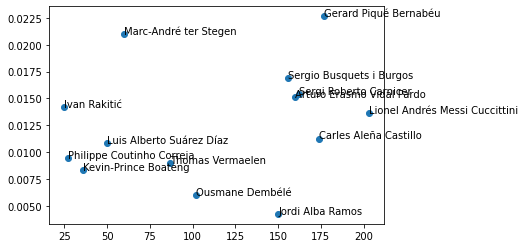

In [ ]:
x = ratings_actions_count["actions_count"]
y = ratings_actions_count["rating"]
plt.scatter(x, y)
for i, player_name in enumerate(ratings_actions_count.index):
    plt.annotate(player_name, (x[i], y[i]))

**Passing evaluation**

In [ ]:
avg_passing_ratings = {
    "female_score": {},
    "female_concede": {},
    "male_score": {},
    "male_concede": {}
}

In [ ]:
male_players_with_ratings_score_passing = {}
male_players_with_ratings_concede_passing = {}
c = 0
t = 0
t_s = 0
t_c = 0
for match_id in ids_m_test:
    match = matches_m[matches_m["match_id"] == match_id]
    home_score = match.iloc[0]["home_score"]
    away_score = match.iloc[0]["away_score"]
    home_team_id = match["home_team"].iloc[0]["home_team_id"]
    away_team_id = match["away_team"].iloc[0]["away_team_id"]
    match_to_rate = transformer(matches_m, [match_id], loader)
    match_to_rate['time_interval'] = classify_time(match_to_rate)
    match_to_rate.drop("time_spent", axis=1, inplace=True)
    match_to_rate_enc = encoder.transform(match_to_rate[["type_name", "result_id", "bodypart_id", "time_interval"]])
    match_to_rate = match_to_rate.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(match_to_rate_enc)).to_numpy()
    df_teams = loader.teams(match_id)
    df_players = loader.players(match_id)
    df_events = loader.events(match_id)
    df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)
    df_actions = (
        spadl.add_names(df_actions)
        .merge(loader.teams(game_id=match_id))
        .merge(loader.players(game_id=match_id))
    )
    df_actions = df_actions.sort_values(by=['action_id'])
    team_ids = df_actions["team_id"]
    match_to_rate_torch = torch.from_numpy(match_to_rate).type(torch.FloatTensor).to(device)
    with torch.no_grad():
        match_to_rate_pred_score=score_model(match_to_rate_torch).flatten()
    with torch.no_grad():
        match_to_rate_pred_concede=concede_model(match_to_rate_torch).flatten()
    match_to_rate_pred_score = match_to_rate_pred_score.cpu().numpy()
    match_to_rate_pred_concede = match_to_rate_pred_concede.cpu().numpy()
    df_actions["score_rating"] = match_to_rate_pred_score
    df_actions["concede_rating"] = match_to_rate_pred_concede
    df_actions["rating"] = match_to_rate_pred_score - match_to_rate_pred_concede
    df_actions = df_actions[df_actions["type_id"] == 0]
    if home_score != away_score:
        c += 1
        team_score_ratings = df_actions[["team_id", "score_rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_score_ratings["score_rating"][home_team_id] > team_score_ratings["score_rating"][away_team_id])) or ((home_score < away_score) and (team_score_ratings["score_rating"][home_team_id] < team_score_ratings["score_rating"][away_team_id])):
            t_s += 1
        team_concede_ratings = df_actions[["team_id", "concede_rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_concede_ratings["concede_rating"][home_team_id] < team_concede_ratings["concede_rating"][away_team_id])) or ((home_score < away_score) and (team_concede_ratings["concede_rating"][home_team_id] > team_concede_ratings["concede_rating"][away_team_id])):
            t_c += 1
        team_ratings = df_actions[["team_id", "rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_ratings["rating"][home_team_id] > team_ratings["rating"][away_team_id])) or ((home_score < away_score) and (team_ratings["rating"][home_team_id] < team_ratings["rating"][away_team_id])):
            t += 1
    score_ratings = df_actions.groupby("player_id").aggregate({'score_rating': 'mean'})
    for i in range(len(score_ratings.index)):
        if score_ratings.index[i] not in male_players_with_ratings_score_passing:
            male_players_with_ratings_score_passing[score_ratings.index[i]] = [score_ratings.iloc[i][0]]
        else:
            male_players_with_ratings_score_passing[score_ratings.index[i]].append(score_ratings.iloc[i][0])
    concede_ratings = df_actions.groupby("player_id").aggregate({'concede_rating': 'mean'})
    for i in range(len(concede_ratings.index)):
        if concede_ratings.index[i] not in male_players_with_ratings_concede_passing:
            male_players_with_ratings_concede_passing[concede_ratings.index[i]] = [concede_ratings.iloc[i][0]]
        else:
            male_players_with_ratings_concede_passing[concede_ratings.index[i]].append(concede_ratings.iloc[i][0])

print('true scoring values =', str(t_s))
print('true conceding values =', str(t_c))
print('true values =', str(t))
print('all scores =', str(c))

true scoring values = 62
true conceding values = 61
true values = 69
all scores = 95


In [ ]:
print(binom_test(62, 95, .5, "greater"))
print(binom_test(61, 95, .5, "greater"))
print(binom_test(69, 95, .5, "greater"))

0.0019164361924377783
0.0036565615697268104
5.914044242457566e-06


In [ ]:
for key, value in male_players_with_ratings_score_passing.items():
    avg_passing_ratings["male_score"][key] = {
        "rating": np.mean(value),
        "matches": len(value)
    }

for key, value in male_players_with_ratings_concede_passing.items():
    avg_passing_ratings["male_concede"][key] = {
        "rating": np.mean(value),
        "matches": len(value)
    }

In [ ]:
female_players_with_ratings_score_passing = {}
female_players_with_ratings_concede_passing = {}
c = 0
t = 0
t_s = 0
t_c = 0
for match_id in ids_f_test:
    match = matches_f[matches_f["match_id"] == match_id]
    home_score = match.iloc[0]["home_score"]
    away_score = match.iloc[0]["away_score"]
    home_team_id = match["home_team"].iloc[0]["home_team_id"]
    away_team_id = match["away_team"].iloc[0]["away_team_id"]
    match_to_rate = transformer(matches_f, [match_id], loader)
    match_to_rate['time_interval'] = classify_time(match_to_rate)
    match_to_rate.drop("time_spent", axis=1, inplace=True)
    match_to_rate_enc = encoder.transform(match_to_rate[["type_name", "result_id", "bodypart_id", "time_interval"]])
    match_to_rate = match_to_rate.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(match_to_rate_enc)).to_numpy()
    df_teams = loader.teams(match_id)
    df_players = loader.players(match_id)
    df_events = loader.events(match_id)
    df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)
    df_actions = (
        spadl.add_names(df_actions)
        .merge(loader.teams(game_id=match_id))
        .merge(loader.players(game_id=match_id))
    )
    df_actions = df_actions.sort_values(by=['action_id'])
    team_ids = df_actions["team_id"]
    match_to_rate_torch = torch.from_numpy(match_to_rate).type(torch.FloatTensor).to(device)
    with torch.no_grad():
        match_to_rate_pred_score=score_model(match_to_rate_torch).flatten()
    with torch.no_grad():
        match_to_rate_pred_concede=concede_model(match_to_rate_torch).flatten()
    match_to_rate_pred_score = match_to_rate_pred_score.cpu().numpy()
    match_to_rate_pred_concede = match_to_rate_pred_concede.cpu().numpy()
    df_actions["score_rating"] = match_to_rate_pred_score
    df_actions["concede_rating"] = match_to_rate_pred_concede
    df_actions["rating"] = match_to_rate_pred_score - match_to_rate_pred_concede
    df_actions = df_actions[df_actions["type_id"] == 0]
    if home_score != away_score:
        c += 1
        team_score_ratings = df_actions[["team_id", "score_rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_score_ratings["score_rating"][home_team_id] > team_score_ratings["score_rating"][away_team_id])) or ((home_score < away_score) and (team_score_ratings["score_rating"][home_team_id] < team_score_ratings["score_rating"][away_team_id])):
            t_s += 1
        team_concede_ratings = df_actions[["team_id", "concede_rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_concede_ratings["concede_rating"][home_team_id] < team_concede_ratings["concede_rating"][away_team_id])) or ((home_score < away_score) and (team_concede_ratings["concede_rating"][home_team_id] > team_concede_ratings["concede_rating"][away_team_id])):
            t_c += 1
        team_ratings = df_actions[["team_id", "rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_ratings["rating"][home_team_id] > team_ratings["rating"][away_team_id])) or ((home_score < away_score) and (team_ratings["rating"][home_team_id] < team_ratings["rating"][away_team_id])):
            t += 1
    score_ratings = df_actions.groupby("player_id").aggregate({'score_rating': 'mean'})
    for i in range(len(score_ratings.index)):
        if score_ratings.index[i] not in female_players_with_ratings_score_passing:
            female_players_with_ratings_score_passing[score_ratings.index[i]] = [score_ratings.iloc[i][0]]
        else:
            female_players_with_ratings_score_passing[score_ratings.index[i]].append(score_ratings.iloc[i][0])
    concede_ratings = df_actions.groupby("player_id").aggregate({'concede_rating': 'mean'})
    for i in range(len(concede_ratings.index)):
        if concede_ratings.index[i] not in female_players_with_ratings_concede_passing:
            female_players_with_ratings_concede_passing[concede_ratings.index[i]] = [concede_ratings.iloc[i][0]]
        else:
            female_players_with_ratings_concede_passing[concede_ratings.index[i]].append(concede_ratings.iloc[i][0])

print('true scoring values =', str(t_s))
print('true conceding values =', str(t_c))
print('true values =', str(t))
print('all scores =', str(c))

true scoring values = 33
true conceding values = 30
true values = 32
all scores = 58


In [ ]:
binom_test(33, 58, .5, "greater")

0.17907165090306884

In [ ]:
for key, value in female_players_with_ratings_score_passing.items():
    avg_passing_ratings["female_score"][key] = {
        "rating": np.mean(value),
        "matches": len(value)
    }

for key, value in female_players_with_ratings_concede_passing.items():
    avg_passing_ratings["female_concede"][key] = {
        "rating": np.mean(value),
        "matches": len(value)
    }

In [ ]:
np.mean([i["rating"] for i in avg_passing_ratings["female_score"].values()])

0.012209630951851612

In [ ]:
np.mean([i["rating"] for i in avg_passing_ratings["male_score"].values()])

0.011975199

In [ ]:
np.mean([i["rating"] for i in avg_passing_ratings["female_concede"].values()])

0.003078434

In [ ]:
np.mean([i["rating"] for i in avg_passing_ratings["male_concede"].values()])

0.002451941

In [ ]:
female_score_passing_ratings = [i["rating"] for i in avg_passing_ratings["female_score"].values()]
male_score_passing_ratings = [i["rating"] for i in avg_passing_ratings["male_score"].values()]

In [ ]:
female_concede_passing_ratings = [i["rating"] for i in avg_passing_ratings["female_concede"].values()]
male_concede_passing_ratings = [i["rating"] for i in avg_passing_ratings["male_concede"].values()]

In [ ]:
with open('./drive/MyDrive/master/dumps/avg_passing_ratings.json', 'wb') as f:
    pickle.dump(avg_passing_ratings, f)

**Successful passes evaluation**

In [ ]:
avg_successful_passing_ratings = {
    "female_score": {},
    "female_concede": {},
    "male_score": {},
    "male_concede": {}
}

In [ ]:
male_players_with_ratings_score_passing_success = {}
male_players_with_ratings_concede_passing_success = {}
c = 0
t = 0
t_s = 0
t_c = 0
for match_id in ids_m_test:
    match = matches_m[matches_m["match_id"] == match_id]
    home_score = match.iloc[0]["home_score"]
    away_score = match.iloc[0]["away_score"]
    home_team_id = match["home_team"].iloc[0]["home_team_id"]
    away_team_id = match["away_team"].iloc[0]["away_team_id"]
    match_to_rate = transformer(matches_m, [match_id], loader)
    match_to_rate['time_interval'] = classify_time(match_to_rate)
    match_to_rate.drop("time_spent", axis=1, inplace=True)
    match_to_rate_enc = encoder.transform(match_to_rate[["type_name", "result_id", "bodypart_id", "time_interval"]])
    match_to_rate = match_to_rate.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(match_to_rate_enc)).to_numpy()
    df_teams = loader.teams(match_id)
    df_players = loader.players(match_id)
    df_events = loader.events(match_id)
    df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)
    df_actions = (
        spadl.add_names(df_actions)
        .merge(loader.teams(game_id=match_id))
        .merge(loader.players(game_id=match_id))
    )
    df_actions = df_actions.sort_values(by=['action_id'])
    team_ids = df_actions["team_id"]
    match_to_rate_torch = torch.from_numpy(match_to_rate).type(torch.FloatTensor).to(device)
    with torch.no_grad():
        match_to_rate_pred_score=score_model(match_to_rate_torch).flatten()
    with torch.no_grad():
        match_to_rate_pred_concede=concede_model(match_to_rate_torch).flatten()
    match_to_rate_pred_score = match_to_rate_pred_score.cpu().numpy()
    match_to_rate_pred_concede = match_to_rate_pred_concede.cpu().numpy()
    df_actions["score_rating"] = match_to_rate_pred_score
    df_actions["concede_rating"] = match_to_rate_pred_concede
    df_actions["rating"] = match_to_rate_pred_score - match_to_rate_pred_concede
    df_actions = df_actions[df_actions["type_id"] == 0]
    df_actions = df_actions[df_actions["result_id"] == 1]
    if home_score != away_score:
        c += 1
        team_score_ratings = df_actions[["team_id", "score_rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_score_ratings["score_rating"][home_team_id] > team_score_ratings["score_rating"][away_team_id])) or ((home_score < away_score) and (team_score_ratings["score_rating"][home_team_id] < team_score_ratings["score_rating"][away_team_id])):
            t_s += 1
        team_concede_ratings = df_actions[["team_id", "concede_rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_concede_ratings["concede_rating"][home_team_id] < team_concede_ratings["concede_rating"][away_team_id])) or ((home_score < away_score) and (team_concede_ratings["concede_rating"][home_team_id] > team_concede_ratings["concede_rating"][away_team_id])):
            t_c += 1
        team_ratings = df_actions[["team_id", "rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_ratings["rating"][home_team_id] > team_ratings["rating"][away_team_id])) or ((home_score < away_score) and (team_ratings["rating"][home_team_id] < team_ratings["rating"][away_team_id])):
            t += 1
    score_ratings = df_actions.groupby("player_id").aggregate({'score_rating': 'mean'})
    for i in range(len(score_ratings.index)):
        if score_ratings.index[i] not in male_players_with_ratings_score_passing_success:
            male_players_with_ratings_score_passing_success[score_ratings.index[i]] = [score_ratings.iloc[i][0]]
        else:
            male_players_with_ratings_score_passing_success[score_ratings.index[i]].append(score_ratings.iloc[i][0])
    concede_ratings = df_actions.groupby("player_id").aggregate({'concede_rating': 'mean'})
    for i in range(len(concede_ratings.index)):
        if concede_ratings.index[i] not in male_players_with_ratings_concede_passing_success:
            male_players_with_ratings_concede_passing_success[concede_ratings.index[i]] = [concede_ratings.iloc[i][0]]
        else:
            male_players_with_ratings_concede_passing_success[concede_ratings.index[i]].append(concede_ratings.iloc[i][0])

print('true scoring values =', str(t_s))
print('true conceding values =', str(t_c))
print('true values =', str(t))
print('all scores =', str(c))

true scoring values = 53
true conceding values = 59
true values = 60
all scores = 95


In [ ]:
print(binom_test(53, 95, .5, "greater"))
print(binom_test(59, 95, .5, "greater"))
print(binom_test(60, 95, .5, "greater"))

0.15244259535113777
0.011744001418460583
0.0066893515130019765


In [ ]:
for key, value in male_players_with_ratings_score_passing_success.items():
    avg_successful_passing_ratings["male_score"][key] = {
        "rating": np.mean(value),
        "matches": len(value)
    }

for key, value in male_players_with_ratings_concede_passing_success.items():
    avg_successful_passing_ratings["male_concede"][key] = {
        "rating": np.mean(value),
        "matches": len(value)
    }

In [ ]:
female_players_with_ratings_score_passing_success = {}
female_players_with_ratings_concede_passing_success = {}
c = 0
t = 0
t_s = 0
t_c = 0
for match_id in ids_f_test:
    match = matches_f[matches_f["match_id"] == match_id]
    home_score = match.iloc[0]["home_score"]
    away_score = match.iloc[0]["away_score"]
    home_team_id = match["home_team"].iloc[0]["home_team_id"]
    away_team_id = match["away_team"].iloc[0]["away_team_id"]
    match_to_rate = transformer(matches_f, [match_id], loader)
    match_to_rate['time_interval'] = classify_time(match_to_rate)
    match_to_rate.drop("time_spent", axis=1, inplace=True)
    match_to_rate_enc = encoder.transform(match_to_rate[["type_name", "result_id", "bodypart_id", "time_interval"]])
    match_to_rate = match_to_rate.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(match_to_rate_enc)).to_numpy()
    df_teams = loader.teams(match_id)
    df_players = loader.players(match_id)
    df_events = loader.events(match_id)
    df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)
    df_actions = (
        spadl.add_names(df_actions)
        .merge(loader.teams(game_id=match_id))
        .merge(loader.players(game_id=match_id))
    )
    df_actions = df_actions.sort_values(by=['action_id'])
    team_ids = df_actions["team_id"]
    match_to_rate_torch = torch.from_numpy(match_to_rate).type(torch.FloatTensor).to(device)
    with torch.no_grad():
        match_to_rate_pred_score=score_model(match_to_rate_torch).flatten()
    with torch.no_grad():
        match_to_rate_pred_concede=concede_model(match_to_rate_torch).flatten()
    match_to_rate_pred_score = match_to_rate_pred_score.cpu().numpy()
    match_to_rate_pred_concede = match_to_rate_pred_concede.cpu().numpy()
    df_actions["score_rating"] = match_to_rate_pred_score
    df_actions["concede_rating"] = match_to_rate_pred_concede
    df_actions["rating"] = match_to_rate_pred_score - match_to_rate_pred_concede
    df_actions = df_actions[df_actions["type_id"] == 0]
    if home_score != away_score:
        c += 1
        team_score_ratings = df_actions[["team_id", "score_rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_score_ratings["score_rating"][home_team_id] > team_score_ratings["score_rating"][away_team_id])) or ((home_score < away_score) and (team_score_ratings["score_rating"][home_team_id] < team_score_ratings["score_rating"][away_team_id])):
            t_s += 1
        team_concede_ratings = df_actions[["team_id", "concede_rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_concede_ratings["concede_rating"][home_team_id] < team_concede_ratings["concede_rating"][away_team_id])) or ((home_score < away_score) and (team_concede_ratings["concede_rating"][home_team_id] > team_concede_ratings["concede_rating"][away_team_id])):
            t_c += 1
        team_ratings = df_actions[["team_id", "rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_ratings["rating"][home_team_id] > team_ratings["rating"][away_team_id])) or ((home_score < away_score) and (team_ratings["rating"][home_team_id] < team_ratings["rating"][away_team_id])):
            t += 1
    score_ratings = df_actions.groupby("player_id").aggregate({'score_rating': 'mean'})
    for i in range(len(score_ratings.index)):
        if score_ratings.index[i] not in female_players_with_ratings_score_passing_success:
            female_players_with_ratings_score_passing_success[score_ratings.index[i]] = [score_ratings.iloc[i][0]]
        else:
            female_players_with_ratings_score_passing_success[score_ratings.index[i]].append(score_ratings.iloc[i][0])
    concede_ratings = df_actions.groupby("player_id").aggregate({'concede_rating': 'mean'})
    for i in range(len(concede_ratings.index)):
        if concede_ratings.index[i] not in female_players_with_ratings_concede_passing_success:
            female_players_with_ratings_concede_passing_success[concede_ratings.index[i]] = [concede_ratings.iloc[i][0]]
        else:
            female_players_with_ratings_concede_passing_success[concede_ratings.index[i]].append(concede_ratings.iloc[i][0])

print('true scoring values =', str(t_s))
print('true conceding values =', str(t_c))
print('true values =', str(t))
print('all scores =', str(c))

true scoring values = 33
true conceding values = 30
true values = 32
all scores = 58


In [ ]:
print(binom_test(33, 58, .5, "greater"))
print(binom_test(30, 58, .5, "greater"))
print(binom_test(32, 58, .5, "greater"))

0.17907165090306884
0.4478416069447956
0.2559211542190845


In [ ]:
for key, value in female_players_with_ratings_score_passing_success.items():
    avg_successful_passing_ratings["female_score"][key] = {
        "rating": np.mean(value),
        "matches": len(value)
    }

for key, value in female_players_with_ratings_concede_passing_success.items():
    avg_successful_passing_ratings["female_concede"][key] = {
        "rating": np.mean(value),
        "matches": len(value)
    }

In [ ]:
female_score_successful_passing_ratings = [i["rating"] for i in avg_successful_passing_ratings["female_score"].values()]
male_score_successful_passing_ratings = [i["rating"] for i in avg_successful_passing_ratings["male_score"].values()]

In [ ]:
np.mean([i["rating"] for i in avg_successful_passing_ratings["female_score"].values()])

0.012321552

In [ ]:
np.mean([i["rating"] for i in avg_successful_passing_ratings["male_score"].values()])

0.012210332

In [ ]:
np.mean([i["rating"] for i in avg_successful_passing_ratings["female_concede"].values()])

0.003078434

In [ ]:
np.mean([i["rating"] for i in avg_successful_passing_ratings["male_concede"].values()])

0.0022255206

In [ ]:
female_concede_successful_passing_ratings = [i["rating"] for i in avg_successful_passing_ratings["female_concede"].values()]
male_concede_successful_passing_ratings = [i["rating"] for i in avg_successful_passing_ratings["male_concede"].values()]

In [ ]:
with open('./drive/MyDrive/master/dumps/avg_successful_passing_ratings.json', 'wb') as f:
    pickle.dump(avg_successful_passing_ratings, f)

**Train a separate model**

In [ ]:
X_f_train['time_interval'] = classify_time(X_f_train)
X_f_train.drop("time_spent", axis=1, inplace=True)
X_f_train_enc = encoder.transform(X_f_train[["type_name", "result_id", "bodypart_id", "time_interval"]])
X_f_train_final = X_f_train.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(X_f_train_enc)).to_numpy()

Learning. n = 5
epoch: 500 , loss= 0.05655848979949951
epoch: 1000 , loss= 0.055292483419179916
epoch: 1500 , loss= 0.054212536662817
epoch: 2000 , loss= 0.05271458625793457
epoch: 2500 , loss= 0.051870815455913544
epoch: 3000 , loss= 0.05106532573699951
epoch: 3500 , loss= 0.05026078596711159


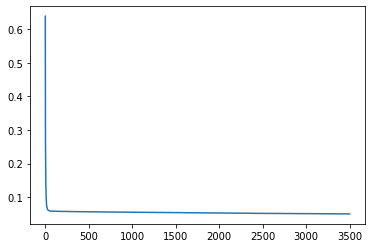

epoch: 500 , loss= 0.0140501968562603
epoch: 1000 , loss= 0.01369757391512394
epoch: 1500 , loss= 0.013522285036742687
epoch: 2000 , loss= 0.013404070399701595
epoch: 2500 , loss= 0.013311615213751793
epoch: 3000 , loss= 0.013232938945293427
epoch: 3500 , loss= 0.013162851333618164


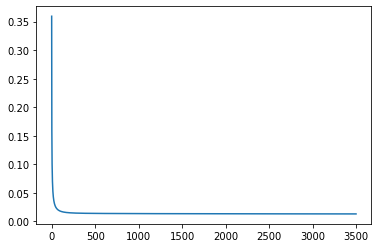

Learning. n = 6
epoch: 500 , loss= 0.06558903306722641
epoch: 1000 , loss= 0.0636523887515068
epoch: 1500 , loss= 0.06210507079958916
epoch: 2000 , loss= 0.060707543045282364
epoch: 2500 , loss= 0.05940792337059975
epoch: 3000 , loss= 0.05817881599068642
epoch: 3500 , loss= 0.0570056289434433


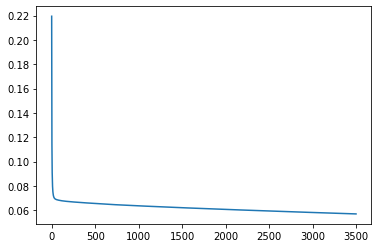

epoch: 500 , loss= 0.018212374299764633
epoch: 1000 , loss= 0.017833847552537918
epoch: 1500 , loss= 0.0176339540630579
epoch: 2000 , loss= 0.017497951164841652
epoch: 2500 , loss= 0.01739288493990898
epoch: 3000 , loss= 0.017303865402936935
epoch: 3500 , loss= 0.017224222421646118


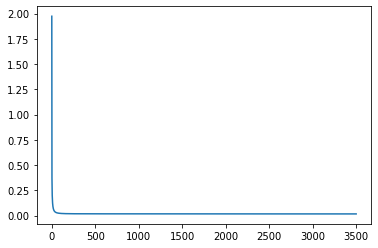

Learning. n = 7
epoch: 500 , loss= 0.06776529550552368
epoch: 1000 , loss= 0.06660754233598709
epoch: 1500 , loss= 0.0655863806605339
epoch: 2000 , loss= 0.06453566998243332
epoch: 2500 , loss= 0.06363289058208466
epoch: 3000 , loss= 0.06278657913208008
epoch: 3500 , loss= 0.061977677047252655


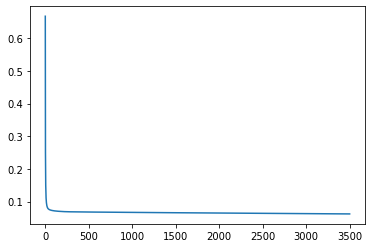

epoch: 500 , loss= 0.02083955891430378
epoch: 1000 , loss= 0.02064429596066475
epoch: 1500 , loss= 0.02049785479903221
epoch: 2000 , loss= 0.02036849595606327
epoch: 2500 , loss= 0.02024787850677967
epoch: 3000 , loss= 0.020131610333919525
epoch: 3500 , loss= 0.020017266273498535


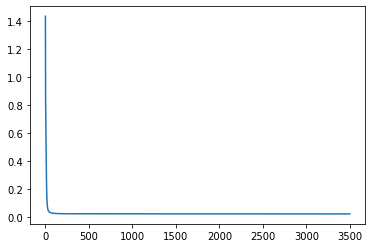

Learning. n = 8
epoch: 500 , loss= 0.07432280480861664
epoch: 1000 , loss= 0.07291099429130554
epoch: 1500 , loss= 0.07152343541383743
epoch: 2000 , loss= 0.0704318955540657
epoch: 2500 , loss= 0.06956256926059723
epoch: 3000 , loss= 0.06874626129865646
epoch: 3500 , loss= 0.0679704025387764


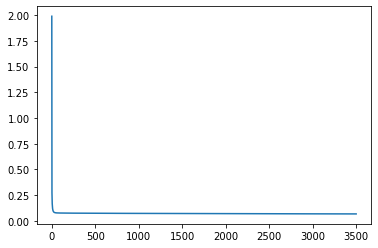

epoch: 500 , loss= 0.02452995628118515
epoch: 1000 , loss= 0.024120615795254707
epoch: 1500 , loss= 0.02387724071741104
epoch: 2000 , loss= 0.02369784191250801
epoch: 2500 , loss= 0.023547345772385597
epoch: 3000 , loss= 0.023412248119711876
epoch: 3500 , loss= 0.023285532370209694


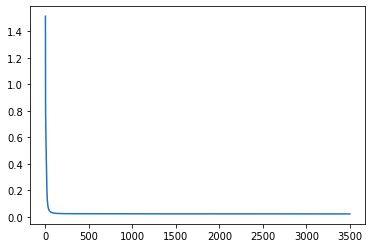

Learning. n = 9
epoch: 500 , loss= 0.08378574252128601
epoch: 1000 , loss= 0.08233471214771271
epoch: 1500 , loss= 0.08104270696640015
epoch: 2000 , loss= 0.07978033274412155
epoch: 2500 , loss= 0.0785466656088829
epoch: 3000 , loss= 0.07732943445444107
epoch: 3500 , loss= 0.0761604905128479


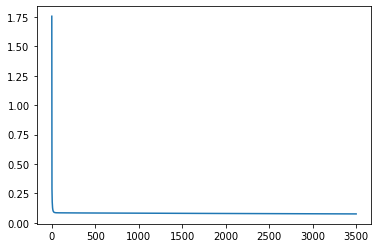

epoch: 500 , loss= 0.028078492730855942
epoch: 1000 , loss= 0.027436021715402603
epoch: 1500 , loss= 0.027049759402871132
epoch: 2000 , loss= 0.02679714933037758
epoch: 2500 , loss= 0.026589179411530495
epoch: 3000 , loss= 0.026396501809358597
epoch: 3500 , loss= 0.026213502511382103


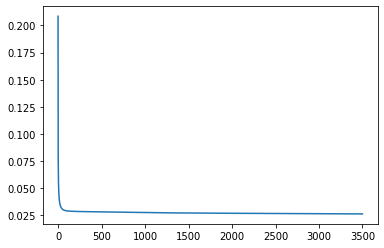

Learning. n = 10
epoch: 500 , loss= 0.0908261314034462
epoch: 1000 , loss= 0.08909816294908524
epoch: 1500 , loss= 0.08748383074998856
epoch: 2000 , loss= 0.08587931841611862
epoch: 2500 , loss= 0.08426150679588318
epoch: 3000 , loss= 0.08263874053955078
epoch: 3500 , loss= 0.08103343099355698


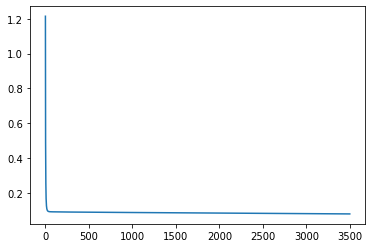

epoch: 500 , loss= 0.03097703866660595
epoch: 1000 , loss= 0.03063170798122883
epoch: 1500 , loss= 0.03039194829761982
epoch: 2000 , loss= 0.030185207724571228
epoch: 2500 , loss= 0.02999117597937584
epoch: 3000 , loss= 0.029802633449435234
epoch: 3500 , loss= 0.029616961255669594


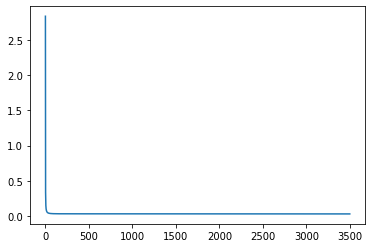

Learning. n = 11
epoch: 500 , loss= 0.09008955955505371
epoch: 1000 , loss= 0.08808120340108871
epoch: 1500 , loss= 0.08654005080461502
epoch: 2000 , loss= 0.08518896996974945
epoch: 2500 , loss= 0.08396762609481812
epoch: 3000 , loss= 0.08281809836626053
epoch: 3500 , loss= 0.08175842463970184


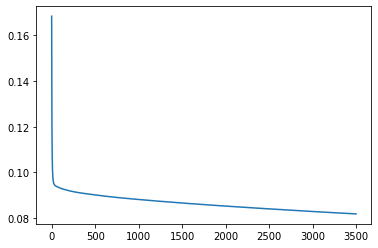

epoch: 500 , loss= 0.033110227435827255
epoch: 1000 , loss= 0.032451871782541275
epoch: 1500 , loss= 0.032091349363327026
epoch: 2000 , loss= 0.03181303292512894
epoch: 2500 , loss= 0.03156561776995659
epoch: 3000 , loss= 0.031334683299064636
epoch: 3500 , loss= 0.03110966645181179


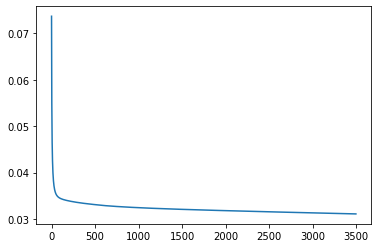

Learning. n = 12
epoch: 500 , loss= 0.09425590932369232
epoch: 1000 , loss= 0.09203295409679413
epoch: 1500 , loss= 0.09048151969909668
epoch: 2000 , loss= 0.08917684853076935
epoch: 2500 , loss= 0.0880362018942833
epoch: 3000 , loss= 0.08702263236045837
epoch: 3500 , loss= 0.08609915524721146


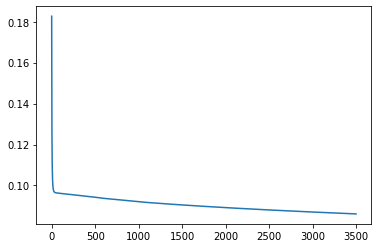

epoch: 500 , loss= 0.03713846206665039
epoch: 1000 , loss= 0.03639284148812294
epoch: 1500 , loss= 0.035956691950559616
epoch: 2000 , loss= 0.03560119867324829
epoch: 2500 , loss= 0.03528081253170967
epoch: 3000 , loss= 0.03498260676860809
epoch: 3500 , loss= 0.03470710292458534


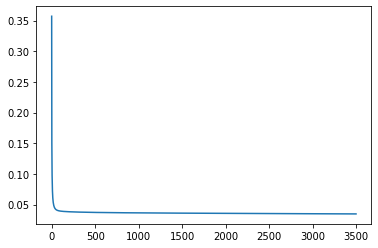

In [ ]:
for n in range(5, 13):
    y_f_score_train = pd.read_csv('./drive/MyDrive/master/dumps/y_score_f_train_' + str(n) + '.csv')
    y_f_concede_train = pd.read_csv('./drive/MyDrive/master/dumps/y_concede_f_train_' + str(n) + '.csv')

    y_score_train = y_f_score_train.astype(int).to_numpy()
    y_concede_train = y_f_concede_train.astype(int).to_numpy()

    x_torch = torch.from_numpy(X_f_train_final).type(torch.FloatTensor).to(device)
    y_torch = torch.from_numpy(y_score_train).type(torch.FloatTensor).reshape(-1, 1).to(device)

    model = NeuralNetwork(n_x).to(device)
    optimizer=torch.optim.SGD(model.parameters(),lr=0.01)

    number_of_epochs=3500
    all_loss = []
    print("Learning. n =", n)
    for epoch in range(number_of_epochs):
        y_prediction=model(x_torch)
        loss=criterion(y_prediction,y_torch)
        loss.backward()
        all_loss.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()
        if (epoch+1)%500 == 0:
            print('epoch:', epoch+1, ', loss=',loss.item())

    plt.figure()
    plt.plot(all_loss)
    plt.show()

    model_save_name = 'score_model_y_f_' + str(n) + '.pt'
    path = F"./drive/MyDrive/master/models/{model_save_name}"
    torch.save(model.state_dict(), path)


    x_torch = torch.from_numpy(X_f_train_final).type(torch.FloatTensor).to(device)
    y_torch = torch.from_numpy(y_concede_train).type(torch.FloatTensor).reshape(-1, 1).to(device)

    model = NeuralNetwork(n_x).to(device)
    optimizer=torch.optim.SGD(model.parameters(),lr=0.0075)


    all_loss = []
    for epoch in range(number_of_epochs):
        y_prediction=model(x_torch)
        loss=criterion(y_prediction,y_torch)
        loss.backward()
        all_loss.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()
        if (epoch+1)%500 == 0:
            print('epoch:', epoch+1, ', loss=',loss.item())

    plt.figure()
    plt.plot(all_loss)
    plt.show()

    model_save_name = 'concede_model_y_f_' + str(n) + '.pt'
    path = F"./drive/MyDrive/master/models/{model_save_name}"
    torch.save(model.state_dict(), path)


**Validate the separate model**

In [ ]:
n_x = 40
model = NeuralNetwork(n_x).to(device)


for n in range(5, 13):

    t = 0
    t_n = 0
    c = 0
    murder_by_numbers = 0

    model_load_name = 'score_model_y_f_' + str(n) + '.pt'
    path = F"./drive/MyDrive/master/models/{model_load_name}"
    model.load_state_dict(torch.load(path))

    for match_id in ids_f_val:
        match = matches_f[matches_f["match_id"] == match_id]
        home_score = match.iloc[0]["home_score"]
        away_score = match.iloc[0]["away_score"]
        if home_score != away_score:
            c += 1
            home_team_id = match["home_team"].iloc[0]["home_team_id"]
            away_team_id = match["away_team"].iloc[0]["away_team_id"]
            match_to_rate = transformer(matches_f, [match_id], loader)
            match_to_rate['time_interval'] = classify_time(match_to_rate)
            match_to_rate.drop("time_spent", axis=1, inplace=True)
            match_to_rate_enc = encoder.transform(match_to_rate[["type_name", "result_id", "bodypart_id", "time_interval"]])
            match_to_rate = match_to_rate.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(match_to_rate_enc)).to_numpy()
            df_teams = loader.teams(match_id)
            df_players = loader.players(match_id)
            df_events = loader.events(match_id)
            df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)
            df_actions = (
                spadl.add_names(df_actions)
                .merge(loader.teams(game_id=match_id))
                .merge(loader.players(game_id=match_id))
            )
            df_actions = df_actions.sort_values(by=['action_id'])
            team_ids = df_actions["team_id"]
            match_to_rate_torch = torch.from_numpy(match_to_rate).type(torch.FloatTensor).to(device)
            with torch.no_grad():
                match_to_rate_pred=model(match_to_rate_torch).flatten()
            match_to_rate_pred = match_to_rate_pred.cpu().numpy()
            df_actions["rating"] = match_to_rate_pred
            team_ratings = df_actions[["team_id", "rating"]].groupby("team_id").agg('mean')
            team_non_shot_ratings = df_actions[df_actions["type_id"] != 11][["team_id", "rating"]].groupby("team_id").agg('mean')
            if ((home_score > away_score) and (team_ratings["rating"][home_team_id] > team_ratings["rating"][away_team_id])) or ((home_score < away_score) and (team_ratings["rating"][home_team_id] < team_ratings["rating"][away_team_id])):
                t += 1
            if ((home_score > away_score) and (team_non_shot_ratings["rating"][home_team_id] > team_non_shot_ratings["rating"][away_team_id])) or ((home_score < away_score) and (team_non_shot_ratings["rating"][home_team_id] < team_non_shot_ratings["rating"][away_team_id])):
                t_n += 1
            home_actions = df_actions[df_actions["team_id"] == home_team_id].shape[0]
            away_actions = df_actions[df_actions["team_id"] == away_team_id].shape[0]
            if ((home_score > away_score) and (home_actions > away_actions)) or ((home_score < away_score) and (home_actions < away_actions)):
                murder_by_numbers += 1
    print('n = ', str(n))
    print('true values =', str(t))
    print('true non shot values =', str(t_n))
    print('all scores = ', str(c))

n =  5
true values = 44
true non shot values = 43
all scores =  75
n =  6
true values = 41
true non shot values = 40
all scores =  75
n =  7
true values = 44
true non shot values = 45
all scores =  75
n =  8
true values = 43
true non shot values = 44
all scores =  75
n =  9
true values = 43
true non shot values = 44
all scores =  75
n =  10
true values = 42
true non shot values = 42
all scores =  75
n =  11
true values = 45
true non shot values = 43
all scores =  75
n =  12
true values = 44
true non shot values = 44
all scores =  75


Learning. n = 11
epoch: 1000 , loss= 0.09123973548412323
epoch: 2000 , loss= 0.08707673847675323
epoch: 3000 , loss= 0.08367905020713806
epoch: 4000 , loss= 0.08079450577497482
epoch: 5000 , loss= 0.07819820940494537
epoch: 6000 , loss= 0.07596784830093384
epoch: 7000 , loss= 0.07410923391580582
epoch: 8000 , loss= 0.07256586104631424
epoch: 9000 , loss= 0.07130111753940582
epoch: 10000 , loss= 0.07029737532138824


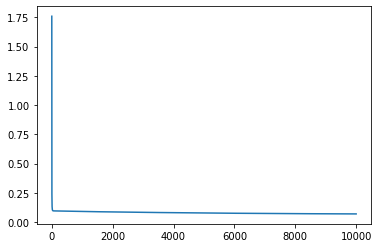

In [ ]:
y_f_score_train = pd.read_csv('./drive/MyDrive/master/dumps/y_score_f_train_11.csv')

y_score_train = y_f_score_train.astype(int).to_numpy()

x_torch = torch.from_numpy(X_f_train_final).type(torch.FloatTensor).to(device)
y_torch = torch.from_numpy(y_score_train).type(torch.FloatTensor).reshape(-1, 1).to(device)

model = NeuralNetwork(n_x).to(device)
optimizer=torch.optim.SGD(model.parameters(),lr=0.01)

number_of_epochs=10000
all_loss = []
print("Learning. n = 11")
for epoch in range(number_of_epochs):
    y_prediction=model(x_torch)
    loss=criterion(y_prediction,y_torch)
    loss.backward()
    all_loss.append(loss.item())
    optimizer.step()
    optimizer.zero_grad()
    if (epoch+1)%1000 == 0:
        print('epoch:', epoch+1, ', loss=',loss.item())

plt.figure()
plt.plot(all_loss)
plt.show()

model_save_name = 'score_model_y_f_extended_11.pt'
path = F"./drive/MyDrive/master/models/{model_save_name}"
torch.save(model.state_dict(), path)


In [ ]:
t = 0
t_n = 0
c = 0
murder_by_numbers = 0

model_load_name = 'score_model_y_f_extended_11.pt'
path = F"./drive/MyDrive/master/models/{model_load_name}"
model.load_state_dict(torch.load(path))

for match_id in ids_f_val:
    match = matches_f[matches_f["match_id"] == match_id]
    home_score = match.iloc[0]["home_score"]
    away_score = match.iloc[0]["away_score"]
    if home_score != away_score:
        c += 1
        home_team_id = match["home_team"].iloc[0]["home_team_id"]
        away_team_id = match["away_team"].iloc[0]["away_team_id"]
        match_to_rate = transformer(matches_f, [match_id], loader)
        match_to_rate['time_interval'] = classify_time(match_to_rate)
        match_to_rate.drop("time_spent", axis=1, inplace=True)
        match_to_rate_enc = encoder.transform(match_to_rate[["type_name", "result_id", "bodypart_id", "time_interval"]])
        match_to_rate = match_to_rate.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(match_to_rate_enc)).to_numpy()
        df_teams = loader.teams(match_id)
        df_players = loader.players(match_id)
        df_events = loader.events(match_id)
        df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)
        df_actions = (
            spadl.add_names(df_actions)
            .merge(loader.teams(game_id=match_id))
            .merge(loader.players(game_id=match_id))
        )
        df_actions = df_actions.sort_values(by=['action_id'])
        team_ids = df_actions["team_id"]
        match_to_rate_torch = torch.from_numpy(match_to_rate).type(torch.FloatTensor).to(device)
        with torch.no_grad():
            match_to_rate_pred=model(match_to_rate_torch).flatten()
        match_to_rate_pred = match_to_rate_pred.cpu().numpy()
        df_actions["rating"] = match_to_rate_pred
        team_ratings = df_actions[["team_id", "rating"]].groupby("team_id").agg('mean')
        team_non_shot_ratings = df_actions[df_actions["type_id"] != 11][["team_id", "rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_ratings["rating"][home_team_id] > team_ratings["rating"][away_team_id])) or ((home_score < away_score) and (team_ratings["rating"][home_team_id] < team_ratings["rating"][away_team_id])):
            t += 1
        if ((home_score > away_score) and (team_non_shot_ratings["rating"][home_team_id] > team_non_shot_ratings["rating"][away_team_id])) or ((home_score < away_score) and (team_non_shot_ratings["rating"][home_team_id] < team_non_shot_ratings["rating"][away_team_id])):
            t_n += 1
        home_actions = df_actions[df_actions["team_id"] == home_team_id].shape[0]
        away_actions = df_actions[df_actions["team_id"] == away_team_id].shape[0]
print('true values =', str(t))
print('true non shot values =', str(t_n))
print('all scores = ', str(c))

true values = 48
true non shot values = 46
all scores =  75


In [ ]:
binom_test(48, 75, .5, alternative='greater')

0.010149203495053714

In [ ]:
n_x = 40
model = NeuralNetwork(n_x).to(device)


for n in range(5, 13):

    t = 0
    t_n = 0
    c = 0
    murder_by_numbers = 0

    model_load_name = 'concede_model_y_f_' + str(n) + '.pt'
    path = F"./drive/MyDrive/master/models/{model_load_name}"
    model.load_state_dict(torch.load(path))

    for match_id in ids_f_val:
        match = matches_f[matches_f["match_id"] == match_id]
        home_score = match.iloc[0]["home_score"]
        away_score = match.iloc[0]["away_score"]
        if home_score != away_score:
            c += 1
            home_team_id = match["home_team"].iloc[0]["home_team_id"]
            away_team_id = match["away_team"].iloc[0]["away_team_id"]
            match_to_rate = transformer(matches_f, [match_id], loader)
            match_to_rate['time_interval'] = classify_time(match_to_rate)
            match_to_rate.drop("time_spent", axis=1, inplace=True)
            match_to_rate_enc = encoder.transform(match_to_rate[["type_name", "result_id", "bodypart_id", "time_interval"]])
            match_to_rate = match_to_rate.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(match_to_rate_enc)).to_numpy()
            df_teams = loader.teams(match_id)
            df_players = loader.players(match_id)
            df_events = loader.events(match_id)
            df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)
            df_actions = (
                spadl.add_names(df_actions)
                .merge(loader.teams(game_id=match_id))
                .merge(loader.players(game_id=match_id))
            )
            df_actions = df_actions.sort_values(by=['action_id'])
            team_ids = df_actions["team_id"]
            match_to_rate_torch = torch.from_numpy(match_to_rate).type(torch.FloatTensor).to(device)
            with torch.no_grad():
                match_to_rate_pred=model(match_to_rate_torch).flatten()
            match_to_rate_pred = match_to_rate_pred.cpu().numpy()
            df_actions["antirating"] = match_to_rate_pred
            team_antiratings = df_actions[["team_id", "antirating"]].groupby("team_id").agg('mean')
            team_non_shot_ratings = df_actions[df_actions["type_id"] != 11][["team_id", "antirating"]].groupby("team_id").agg('mean')
            if ((home_score > away_score) and (team_antiratings["antirating"][home_team_id] < team_antiratings["antirating"][away_team_id])) or ((home_score < away_score) and (team_antiratings["antirating"][home_team_id] > team_antiratings["antirating"][away_team_id])):
                t += 1
    print('n = ', str(n))
    print('true values =', str(t))
    print('true non shot values =', str(t_n))
    print('all scores =', str(c))

n =  5
true values = 38
true non shot values = 0
all scores = 75
n =  6
true values = 37
true non shot values = 0
all scores = 75
n =  7
true values = 37
true non shot values = 0
all scores = 75
n =  8
true values = 36
true non shot values = 0
all scores = 75
n =  9
true values = 37
true non shot values = 0
all scores = 75
n =  10
true values = 33
true non shot values = 0
all scores = 75
n =  11
true values = 31
true non shot values = 0
all scores = 75
n =  12
true values = 31
true non shot values = 0
all scores = 75


epoch: 1000 , loss= 0.01410540472716093
epoch: 2000 , loss= 0.013760527595877647
epoch: 3000 , loss= 0.013567907735705376
epoch: 4000 , loss= 0.01343559194356203
epoch: 5000 , loss= 0.013329094275832176
epoch: 6000 , loss= 0.01323531661182642
epoch: 7000 , loss= 0.013148385100066662
epoch: 8000 , loss= 0.013063936494290829
epoch: 9000 , loss= 0.012981035746634007
epoch: 10000 , loss= 0.012899703346192837


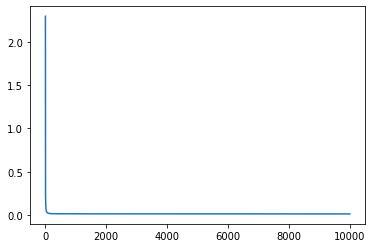

In [ ]:
y_f_concede_train = pd.read_csv('./drive/MyDrive/master/dumps/y_concede_f_train_5.csv')

y_concede_train = y_f_concede_train.astype(int).to_numpy()

x_torch = torch.from_numpy(X_f_train_final).type(torch.FloatTensor).to(device)
y_torch = torch.from_numpy(y_concede_train).type(torch.FloatTensor).reshape(-1, 1).to(device)

model = NeuralNetwork(n_x).to(device)
optimizer=torch.optim.SGD(model.parameters(),lr=0.0075)

number_of_epochs=10000
all_loss = []
for epoch in range(number_of_epochs):
    y_prediction=model(x_torch)
    loss=criterion(y_prediction,y_torch)
    loss.backward()
    all_loss.append(loss.item())
    optimizer.step()
    optimizer.zero_grad()
    if (epoch+1)%1000 == 0:
        print('epoch:', epoch+1, ', loss=',loss.item())

plt.figure()
plt.plot(all_loss)
plt.show()

model_save_name = 'concede_model_y_f_extended_5.pt'
path = F"./drive/MyDrive/master/models/{model_save_name}"
torch.save(model.state_dict(), path)


In [ ]:
n_x = 40
model = NeuralNetwork(n_x).to(device)

t = 0
t_n = 0
c = 0
murder_by_numbers = 0

model_load_name = 'concede_model_y_f_extended_5.pt'
path = F"./drive/MyDrive/master/models/{model_load_name}"
model.load_state_dict(torch.load(path))

for match_id in ids_f_val:
    match = matches_f[matches_f["match_id"] == match_id]
    home_score = match.iloc[0]["home_score"]
    away_score = match.iloc[0]["away_score"]
    if home_score != away_score:
        c += 1
        home_team_id = match["home_team"].iloc[0]["home_team_id"]
        away_team_id = match["away_team"].iloc[0]["away_team_id"]
        match_to_rate = transformer(matches_f, [match_id], loader)
        match_to_rate['time_interval'] = classify_time(match_to_rate)
        match_to_rate.drop("time_spent", axis=1, inplace=True)
        match_to_rate_enc = encoder.transform(match_to_rate[["type_name", "result_id", "bodypart_id", "time_interval"]])
        match_to_rate = match_to_rate.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(match_to_rate_enc)).to_numpy()
        df_teams = loader.teams(match_id)
        df_players = loader.players(match_id)
        df_events = loader.events(match_id)
        df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)
        df_actions = (
            spadl.add_names(df_actions)
            .merge(loader.teams(game_id=match_id))
            .merge(loader.players(game_id=match_id))
        )
        df_actions = df_actions.sort_values(by=['action_id'])
        team_ids = df_actions["team_id"]
        match_to_rate_torch = torch.from_numpy(match_to_rate).type(torch.FloatTensor).to(device)
        with torch.no_grad():
            match_to_rate_pred=model(match_to_rate_torch).flatten()
        match_to_rate_pred = match_to_rate_pred.cpu().numpy()
        df_actions["antirating"] = match_to_rate_pred
        team_antiratings = df_actions[["team_id", "antirating"]].groupby("team_id").agg('mean')
        team_non_shot_ratings = df_actions[df_actions["type_id"] != 11][["team_id", "antirating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_antiratings["antirating"][home_team_id] < team_antiratings["antirating"][away_team_id])) or ((home_score < away_score) and (team_antiratings["antirating"][home_team_id] > team_antiratings["antirating"][away_team_id])):
            t += 1
        home_actions = df_actions[df_actions["team_id"] == home_team_id].shape[0]
        away_actions = df_actions[df_actions["team_id"] == away_team_id].shape[0]
        if ((home_score < away_score) and (home_actions > away_actions)) or ((home_score > away_score) and (home_actions < away_actions)):
            murder_by_numbers += 1

print('true values =', str(t))
print('true non shot values =', str(t_n))
print('all scores =', str(c))

n =  12
true values = 39
true non shot values = 0
all scores = 75
victory by number of actions = 23


In [ ]:
binom_test(43, 75, .5, "greater")

0.12402287094626394

epoch: 1000 , loss= 0.013511520810425282
epoch: 2000 , loss= 0.013348427601158619
epoch: 3000 , loss= 0.013219306245446205
epoch: 4000 , loss= 0.013108264654874802
epoch: 5000 , loss= 0.013015608303248882


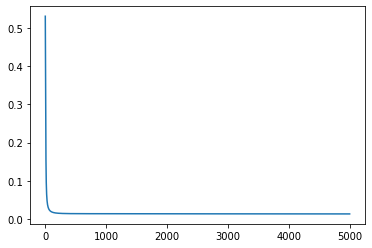

In [ ]:
y_f_concede_train = pd.read_csv('./drive/MyDrive/master/dumps/y_concede_f_train_5.csv')

y_concede_train = y_f_concede_train.astype(int).to_numpy()

x_torch = torch.from_numpy(X_f_train_final).type(torch.FloatTensor).to(device)
y_torch = torch.from_numpy(y_concede_train).type(torch.FloatTensor).reshape(-1, 1).to(device)

model = NeuralNetwork(n_x).to(device)
optimizer=torch.optim.SGD(model.parameters(),lr=0.0075)

number_of_epochs=5000
all_loss = []
for epoch in range(number_of_epochs):
    y_prediction=model(x_torch)
    loss=criterion(y_prediction,y_torch)
    loss.backward()
    all_loss.append(loss.item())
    optimizer.step()
    optimizer.zero_grad()
    if (epoch+1)%1000 == 0:
        print('epoch:', epoch+1, ', loss=',loss.item())

plt.figure()
plt.plot(all_loss)
plt.show()

model_save_name = 'concede_model_y_f_semi_extended_5.pt'
path = F"./drive/MyDrive/master/models/{model_save_name}"
torch.save(model.state_dict(), path)


In [ ]:
n_x = 40
model = NeuralNetwork(n_x).to(device)

t = 0
c = 0

model_load_name = 'concede_model_y_f_semi_extended_5.pt'
path = F"./drive/MyDrive/master/models/{model_load_name}"
model.load_state_dict(torch.load(path))

for match_id in ids_f_val:
    match = matches_f[matches_f["match_id"] == match_id]
    home_score = match.iloc[0]["home_score"]
    away_score = match.iloc[0]["away_score"]
    if home_score != away_score:
        c += 1
        home_team_id = match["home_team"].iloc[0]["home_team_id"]
        away_team_id = match["away_team"].iloc[0]["away_team_id"]
        match_to_rate = transformer(matches_f, [match_id], loader)
        match_to_rate['time_interval'] = classify_time(match_to_rate)
        match_to_rate.drop("time_spent", axis=1, inplace=True)
        match_to_rate_enc = encoder.transform(match_to_rate[["type_name", "result_id", "bodypart_id", "time_interval"]])
        match_to_rate = match_to_rate.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(match_to_rate_enc)).to_numpy()
        df_teams = loader.teams(match_id)
        df_players = loader.players(match_id)
        df_events = loader.events(match_id)
        df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)
        df_actions = (
            spadl.add_names(df_actions)
            .merge(loader.teams(game_id=match_id))
            .merge(loader.players(game_id=match_id))
        )
        df_actions = df_actions.sort_values(by=['action_id'])
        team_ids = df_actions["team_id"]
        match_to_rate_torch = torch.from_numpy(match_to_rate).type(torch.FloatTensor).to(device)
        with torch.no_grad():
            match_to_rate_pred=model(match_to_rate_torch).flatten()
        match_to_rate_pred = match_to_rate_pred.cpu().numpy()
        df_actions["antirating"] = match_to_rate_pred
        team_antiratings = df_actions[["team_id", "antirating"]].groupby("team_id").agg('mean')
        team_non_shot_ratings = df_actions[df_actions["type_id"] != 11][["team_id", "antirating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_antiratings["antirating"][home_team_id] < team_antiratings["antirating"][away_team_id])) or ((home_score < away_score) and (team_antiratings["antirating"][home_team_id] > team_antiratings["antirating"][away_team_id])):
            t += 1
        home_actions = df_actions[df_actions["team_id"] == home_team_id].shape[0]
        away_actions = df_actions[df_actions["team_id"] == away_team_id].shape[0]
        if ((home_score < away_score) and (home_actions > away_actions)) or ((home_score > away_score) and (home_actions < away_actions)):
            murder_by_numbers += 1

print('true values =', str(t))
print('all scores =', str(c))

true values = 37
all scores = 75


epoch: 1000 , loss= 0.01670580357313156
epoch: 2000 , loss= 0.016402779147028923
epoch: 3000 , loss= 0.016192087903618813
epoch: 4000 , loss= 0.016026770696043968
epoch: 5000 , loss= 0.01589841954410076
epoch: 6000 , loss= 0.01577785052359104
epoch: 7000 , loss= 0.01565822772681713
epoch: 8000 , loss= 0.015536569058895111
epoch: 9000 , loss= 0.015409138984978199
epoch: 10000 , loss= 0.01528097316622734


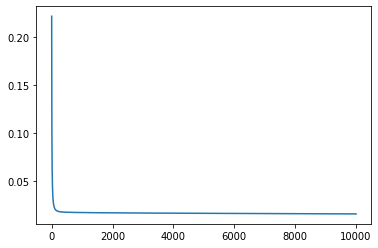

In [ ]:
y_f_concede_train = pd.read_csv('./drive/MyDrive/master/dumps/y_concede_f_train_6.csv')

y_concede_train = y_f_concede_train.astype(int).to_numpy()

x_torch = torch.from_numpy(X_f_train_final).type(torch.FloatTensor).to(device)
y_torch = torch.from_numpy(y_concede_train).type(torch.FloatTensor).reshape(-1, 1).to(device)

model = NeuralNetwork(n_x).to(device)
optimizer=torch.optim.SGD(model.parameters(),lr=0.0075)

number_of_epochs=10000
all_loss = []
for epoch in range(number_of_epochs):
    y_prediction=model(x_torch)
    loss=criterion(y_prediction,y_torch)
    loss.backward()
    all_loss.append(loss.item())
    optimizer.step()
    optimizer.zero_grad()
    if (epoch+1)%1000 == 0:
        print('epoch:', epoch+1, ', loss=',loss.item())

plt.figure()
plt.plot(all_loss)
plt.show()

model_save_name = 'concede_model_y_f_extended_6.pt'
path = F"./drive/MyDrive/master/models/{model_save_name}"
torch.save(model.state_dict(), path)


In [ ]:
n_x = 40
model = NeuralNetwork(n_x).to(device)

t = 0
c = 0

model_load_name = 'concede_model_y_f_extended_6.pt'
path = F"./drive/MyDrive/master/models/{model_load_name}"
model.load_state_dict(torch.load(path))

for match_id in ids_f_val:
    match = matches_f[matches_f["match_id"] == match_id]
    home_score = match.iloc[0]["home_score"]
    away_score = match.iloc[0]["away_score"]
    if home_score != away_score:
        c += 1
        home_team_id = match["home_team"].iloc[0]["home_team_id"]
        away_team_id = match["away_team"].iloc[0]["away_team_id"]
        match_to_rate = transformer(matches_f, [match_id], loader)
        match_to_rate['time_interval'] = classify_time(match_to_rate)
        match_to_rate.drop("time_spent", axis=1, inplace=True)
        match_to_rate_enc = encoder.transform(match_to_rate[["type_name", "result_id", "bodypart_id", "time_interval"]])
        match_to_rate = match_to_rate.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(match_to_rate_enc)).to_numpy()
        df_teams = loader.teams(match_id)
        df_players = loader.players(match_id)
        df_events = loader.events(match_id)
        df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)
        df_actions = (
            spadl.add_names(df_actions)
            .merge(loader.teams(game_id=match_id))
            .merge(loader.players(game_id=match_id))
        )
        df_actions = df_actions.sort_values(by=['action_id'])
        team_ids = df_actions["team_id"]
        match_to_rate_torch = torch.from_numpy(match_to_rate).type(torch.FloatTensor).to(device)
        with torch.no_grad():
            match_to_rate_pred=model(match_to_rate_torch).flatten()
        match_to_rate_pred = match_to_rate_pred.cpu().numpy()
        df_actions["antirating"] = match_to_rate_pred
        team_antiratings = df_actions[["team_id", "antirating"]].groupby("team_id").agg('mean')
        team_non_shot_ratings = df_actions[df_actions["type_id"] != 11][["team_id", "antirating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_antiratings["antirating"][home_team_id] < team_antiratings["antirating"][away_team_id])) or ((home_score < away_score) and (team_antiratings["antirating"][home_team_id] > team_antiratings["antirating"][away_team_id])):
            t += 1
        home_actions = df_actions[df_actions["team_id"] == home_team_id].shape[0]
        away_actions = df_actions[df_actions["team_id"] == away_team_id].shape[0]
        if ((home_score < away_score) and (home_actions > away_actions)) or ((home_score > away_score) and (home_actions < away_actions)):
            murder_by_numbers += 1

print('true values =', str(t))
print('all scores =', str(c))

true values = 36
all scores = 75


epoch: 1000 , loss= 0.016633132472634315
epoch: 2000 , loss= 0.016422485932707787


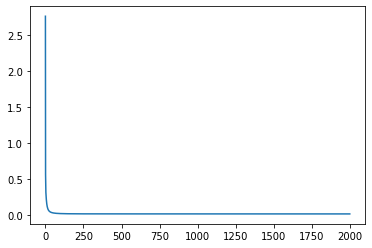

In [ ]:
y_f_concede_train = pd.read_csv('./drive/MyDrive/master/dumps/y_concede_f_train_6.csv')

y_concede_train = y_f_concede_train.astype(int).to_numpy()

x_torch = torch.from_numpy(X_f_train_final).type(torch.FloatTensor).to(device)
y_torch = torch.from_numpy(y_concede_train).type(torch.FloatTensor).reshape(-1, 1).to(device)

model = NeuralNetwork(n_x).to(device)
optimizer=torch.optim.SGD(model.parameters(),lr=0.0075)

number_of_epochs=2000
all_loss = []
for epoch in range(number_of_epochs):
    y_prediction=model(x_torch)
    loss=criterion(y_prediction,y_torch)
    loss.backward()
    all_loss.append(loss.item())
    optimizer.step()
    optimizer.zero_grad()
    if (epoch+1)%1000 == 0:
        print('epoch:', epoch+1, ', loss=',loss.item())

plt.figure()
plt.plot(all_loss)
plt.show()

model_save_name = 'concede_model_y_f_small_6.pt'
path = F"./drive/MyDrive/master/models/{model_save_name}"
torch.save(model.state_dict(), path)


In [ ]:
n_x = 40
model = NeuralNetwork(n_x).to(device)

t = 0
c = 0

model_load_name = 'concede_model_y_f_small_6.pt'
path = F"./drive/MyDrive/master/models/{model_load_name}"
model.load_state_dict(torch.load(path))

for match_id in ids_f_val:
    match = matches_f[matches_f["match_id"] == match_id]
    home_score = match.iloc[0]["home_score"]
    away_score = match.iloc[0]["away_score"]
    if home_score != away_score:
        c += 1
        home_team_id = match["home_team"].iloc[0]["home_team_id"]
        away_team_id = match["away_team"].iloc[0]["away_team_id"]
        match_to_rate = transformer(matches_f, [match_id], loader)
        match_to_rate['time_interval'] = classify_time(match_to_rate)
        match_to_rate.drop("time_spent", axis=1, inplace=True)
        match_to_rate_enc = encoder.transform(match_to_rate[["type_name", "result_id", "bodypart_id", "time_interval"]])
        match_to_rate = match_to_rate.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(match_to_rate_enc)).to_numpy()
        df_teams = loader.teams(match_id)
        df_players = loader.players(match_id)
        df_events = loader.events(match_id)
        df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)
        df_actions = (
            spadl.add_names(df_actions)
            .merge(loader.teams(game_id=match_id))
            .merge(loader.players(game_id=match_id))
        )
        df_actions = df_actions.sort_values(by=['action_id'])
        team_ids = df_actions["team_id"]
        match_to_rate_torch = torch.from_numpy(match_to_rate).type(torch.FloatTensor).to(device)
        with torch.no_grad():
            match_to_rate_pred=model(match_to_rate_torch).flatten()
        match_to_rate_pred = match_to_rate_pred.cpu().numpy()
        df_actions["antirating"] = match_to_rate_pred
        team_antiratings = df_actions[["team_id", "antirating"]].groupby("team_id").agg('mean')
        team_non_shot_ratings = df_actions[df_actions["type_id"] != 11][["team_id", "antirating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_antiratings["antirating"][home_team_id] < team_antiratings["antirating"][away_team_id])) or ((home_score < away_score) and (team_antiratings["antirating"][home_team_id] > team_antiratings["antirating"][away_team_id])):
            t += 1
        home_actions = df_actions[df_actions["team_id"] == home_team_id].shape[0]
        away_actions = df_actions[df_actions["team_id"] == away_team_id].shape[0]
        if ((home_score < away_score) and (home_actions > away_actions)) or ((home_score > away_score) and (home_actions < away_actions)):
            murder_by_numbers += 1

print('true values =', str(t))
print('all scores =', str(c))

true values = 40
all scores = 75


epoch: 1000 , loss= 0.017804177477955818
epoch: 2000 , loss= 0.017566721886396408


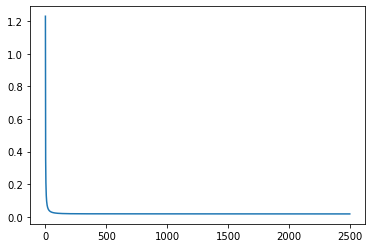

In [ ]:
y_f_concede_train = pd.read_csv('./drive/MyDrive/master/dumps/y_concede_f_train_6.csv')

y_concede_train = y_f_concede_train.astype(int).to_numpy()

x_torch = torch.from_numpy(X_f_train_final).type(torch.FloatTensor).to(device)
y_torch = torch.from_numpy(y_concede_train).type(torch.FloatTensor).reshape(-1, 1).to(device)

model = NeuralNetwork(n_x).to(device)
optimizer=torch.optim.SGD(model.parameters(),lr=0.0075)

number_of_epochs=2500
all_loss = []
for epoch in range(number_of_epochs):
    y_prediction=model(x_torch)
    loss=criterion(y_prediction,y_torch)
    loss.backward()
    all_loss.append(loss.item())
    optimizer.step()
    optimizer.zero_grad()
    if (epoch+1)%1000 == 0:
        print('epoch:', epoch+1, ', loss=',loss.item())

plt.figure()
plt.plot(all_loss)
plt.show()

model_save_name = 'concede_model_y_f_middle_6.pt'
path = F"./drive/MyDrive/master/models/{model_save_name}"
torch.save(model.state_dict(), path)


In [ ]:
n_x = 40
model = NeuralNetwork(n_x).to(device)

t = 0
c = 0

model_load_name = 'concede_model_y_f_middle_6.pt'
path = F"./drive/MyDrive/master/models/{model_load_name}"
model.load_state_dict(torch.load(path))

for match_id in ids_f_val:
    match = matches_f[matches_f["match_id"] == match_id]
    home_score = match.iloc[0]["home_score"]
    away_score = match.iloc[0]["away_score"]
    if home_score != away_score:
        c += 1
        home_team_id = match["home_team"].iloc[0]["home_team_id"]
        away_team_id = match["away_team"].iloc[0]["away_team_id"]
        match_to_rate = transformer(matches_f, [match_id], loader)
        match_to_rate['time_interval'] = classify_time(match_to_rate)
        match_to_rate.drop("time_spent", axis=1, inplace=True)
        match_to_rate_enc = encoder.transform(match_to_rate[["type_name", "result_id", "bodypart_id", "time_interval"]])
        match_to_rate = match_to_rate.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(match_to_rate_enc)).to_numpy()
        df_teams = loader.teams(match_id)
        df_players = loader.players(match_id)
        df_events = loader.events(match_id)
        df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)
        df_actions = (
            spadl.add_names(df_actions)
            .merge(loader.teams(game_id=match_id))
            .merge(loader.players(game_id=match_id))
        )
        df_actions = df_actions.sort_values(by=['action_id'])
        team_ids = df_actions["team_id"]
        match_to_rate_torch = torch.from_numpy(match_to_rate).type(torch.FloatTensor).to(device)
        with torch.no_grad():
            match_to_rate_pred=model(match_to_rate_torch).flatten()
        match_to_rate_pred = match_to_rate_pred.cpu().numpy()
        df_actions["antirating"] = match_to_rate_pred
        team_antiratings = df_actions[["team_id", "antirating"]].groupby("team_id").agg('mean')
        team_non_shot_ratings = df_actions[df_actions["type_id"] != 11][["team_id", "antirating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_antiratings["antirating"][home_team_id] < team_antiratings["antirating"][away_team_id])) or ((home_score < away_score) and (team_antiratings["antirating"][home_team_id] > team_antiratings["antirating"][away_team_id])):
            t += 1
        home_actions = df_actions[df_actions["team_id"] == home_team_id].shape[0]
        away_actions = df_actions[df_actions["team_id"] == away_team_id].shape[0]
        if ((home_score < away_score) and (home_actions > away_actions)) or ((home_score > away_score) and (home_actions < away_actions)):
            murder_by_numbers += 1

print('true values =', str(t))
print('all scores =', str(c))

true values = 38
all scores = 75


epoch: 1000 , loss= 0.01352720707654953
epoch: 2000 , loss= 0.013340218923985958


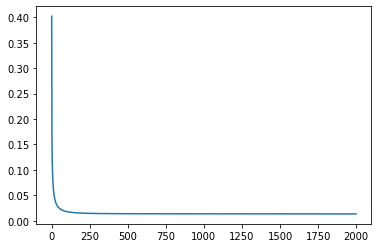

In [ ]:
y_f_concede_train = pd.read_csv('./drive/MyDrive/master/dumps/y_concede_f_train_5.csv')

y_concede_train = y_f_concede_train.astype(int).to_numpy()

x_torch = torch.from_numpy(X_f_train_final).type(torch.FloatTensor).to(device)
y_torch = torch.from_numpy(y_concede_train).type(torch.FloatTensor).reshape(-1, 1).to(device)

model = NeuralNetwork(n_x).to(device)
optimizer=torch.optim.SGD(model.parameters(),lr=0.0075)

number_of_epochs=2000
all_loss = []
for epoch in range(number_of_epochs):
    y_prediction=model(x_torch)
    loss=criterion(y_prediction,y_torch)
    loss.backward()
    all_loss.append(loss.item())
    optimizer.step()
    optimizer.zero_grad()
    if (epoch+1)%1000 == 0:
        print('epoch:', epoch+1, ', loss=',loss.item())

plt.figure()
plt.plot(all_loss)
plt.show()

model_save_name = 'concede_model_y_f_small_5.pt'
path = F"./drive/MyDrive/master/models/{model_save_name}"
torch.save(model.state_dict(), path)


In [ ]:
n_x = 40
model = NeuralNetwork(n_x).to(device)

t = 0
c = 0

model_load_name = 'concede_model_y_f_small_5.pt'
path = F"./drive/MyDrive/master/models/{model_load_name}"
model.load_state_dict(torch.load(path))

for match_id in ids_f_val:
    match = matches_f[matches_f["match_id"] == match_id]
    home_score = match.iloc[0]["home_score"]
    away_score = match.iloc[0]["away_score"]
    if home_score != away_score:
        c += 1
        home_team_id = match["home_team"].iloc[0]["home_team_id"]
        away_team_id = match["away_team"].iloc[0]["away_team_id"]
        match_to_rate = transformer(matches_f, [match_id], loader)
        match_to_rate['time_interval'] = classify_time(match_to_rate)
        match_to_rate.drop("time_spent", axis=1, inplace=True)
        match_to_rate_enc = encoder.transform(match_to_rate[["type_name", "result_id", "bodypart_id", "time_interval"]])
        match_to_rate = match_to_rate.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(match_to_rate_enc)).to_numpy()
        df_teams = loader.teams(match_id)
        df_players = loader.players(match_id)
        df_events = loader.events(match_id)
        df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)
        df_actions = (
            spadl.add_names(df_actions)
            .merge(loader.teams(game_id=match_id))
            .merge(loader.players(game_id=match_id))
        )
        df_actions = df_actions.sort_values(by=['action_id'])
        team_ids = df_actions["team_id"]
        match_to_rate_torch = torch.from_numpy(match_to_rate).type(torch.FloatTensor).to(device)
        with torch.no_grad():
            match_to_rate_pred=model(match_to_rate_torch).flatten()
        match_to_rate_pred = match_to_rate_pred.cpu().numpy()
        df_actions["antirating"] = match_to_rate_pred
        team_antiratings = df_actions[["team_id", "antirating"]].groupby("team_id").agg('mean')
        team_non_shot_ratings = df_actions[df_actions["type_id"] != 11][["team_id", "antirating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_antiratings["antirating"][home_team_id] < team_antiratings["antirating"][away_team_id])) or ((home_score < away_score) and (team_antiratings["antirating"][home_team_id] > team_antiratings["antirating"][away_team_id])):
            t += 1
        home_actions = df_actions[df_actions["team_id"] == home_team_id].shape[0]
        away_actions = df_actions[df_actions["team_id"] == away_team_id].shape[0]
        if ((home_score < away_score) and (home_actions > away_actions)) or ((home_score > away_score) and (home_actions < away_actions)):
            murder_by_numbers += 1

print('true values =', str(t))
print('all scores =', str(c))

true values = 35
all scores = 75


epoch: 1000 , loss= 0.020042050629854202
epoch: 2000 , loss= 0.01977907493710518


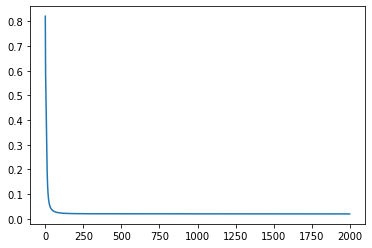

In [ ]:
y_f_concede_train = pd.read_csv('./drive/MyDrive/master/dumps/y_concede_f_train_7.csv')

y_concede_train = y_f_concede_train.astype(int).to_numpy()

x_torch = torch.from_numpy(X_f_train_final).type(torch.FloatTensor).to(device)
y_torch = torch.from_numpy(y_concede_train).type(torch.FloatTensor).reshape(-1, 1).to(device)

model = NeuralNetwork(n_x).to(device)
optimizer=torch.optim.SGD(model.parameters(),lr=0.0075)

number_of_epochs=2000
all_loss = []
for epoch in range(number_of_epochs):
    y_prediction=model(x_torch)
    loss=criterion(y_prediction,y_torch)
    loss.backward()
    all_loss.append(loss.item())
    optimizer.step()
    optimizer.zero_grad()
    if (epoch+1)%1000 == 0:
        print('epoch:', epoch+1, ', loss=',loss.item())

plt.figure()
plt.plot(all_loss)
plt.show()

model_save_name = 'concede_model_y_f_small_7.pt'
path = F"./drive/MyDrive/master/models/{model_save_name}"
torch.save(model.state_dict(), path)


In [ ]:
n_x = 40
model = NeuralNetwork(n_x).to(device)

t = 0
c = 0

model_load_name = 'concede_model_y_f_small_7.pt'
path = F"./drive/MyDrive/master/models/{model_load_name}"
model.load_state_dict(torch.load(path))

for match_id in ids_f_val:
    match = matches_f[matches_f["match_id"] == match_id]
    home_score = match.iloc[0]["home_score"]
    away_score = match.iloc[0]["away_score"]
    if home_score != away_score:
        c += 1
        home_team_id = match["home_team"].iloc[0]["home_team_id"]
        away_team_id = match["away_team"].iloc[0]["away_team_id"]
        match_to_rate = transformer(matches_f, [match_id], loader)
        match_to_rate['time_interval'] = classify_time(match_to_rate)
        match_to_rate.drop("time_spent", axis=1, inplace=True)
        match_to_rate_enc = encoder.transform(match_to_rate[["type_name", "result_id", "bodypart_id", "time_interval"]])
        match_to_rate = match_to_rate.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(match_to_rate_enc)).to_numpy()
        df_teams = loader.teams(match_id)
        df_players = loader.players(match_id)
        df_events = loader.events(match_id)
        df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)
        df_actions = (
            spadl.add_names(df_actions)
            .merge(loader.teams(game_id=match_id))
            .merge(loader.players(game_id=match_id))
        )
        df_actions = df_actions.sort_values(by=['action_id'])
        team_ids = df_actions["team_id"]
        match_to_rate_torch = torch.from_numpy(match_to_rate).type(torch.FloatTensor).to(device)
        with torch.no_grad():
            match_to_rate_pred=model(match_to_rate_torch).flatten()
        match_to_rate_pred = match_to_rate_pred.cpu().numpy()
        df_actions["antirating"] = match_to_rate_pred
        team_antiratings = df_actions[["team_id", "antirating"]].groupby("team_id").agg('mean')
        team_non_shot_ratings = df_actions[df_actions["type_id"] != 11][["team_id", "antirating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_antiratings["antirating"][home_team_id] < team_antiratings["antirating"][away_team_id])) or ((home_score < away_score) and (team_antiratings["antirating"][home_team_id] > team_antiratings["antirating"][away_team_id])):
            t += 1

print('true values =', str(t))
print('all scores =', str(c))

true values = 38
all scores = 75


In [ ]:
n_x = 40

In [ ]:
score_model = NeuralNetwork(n_x).to(device)
model_load_name = 'score_model_y_f_extended_11.pt'
path = F"./drive/MyDrive/master/models/{model_load_name}"
score_model.load_state_dict(torch.load(path))

concede_model = NeuralNetwork(n_x).to(device)
model_load_name = 'concede_model_y_f_small_6.pt'
path = F"./drive/MyDrive/master/models/{model_load_name}"
concede_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
t = 0
t_n = 0
c = 0

for match_id in ids_f_val:
    match = matches_f[matches_f["match_id"] == match_id]
    home_score = match.iloc[0]["home_score"]
    away_score = match.iloc[0]["away_score"]
    if home_score != away_score:
        c += 1
        home_team_id = match["home_team"].iloc[0]["home_team_id"]
        away_team_id = match["away_team"].iloc[0]["away_team_id"]
        match_to_rate = transformer(matches_f, [match_id], loader)
        match_to_rate['time_interval'] = classify_time(match_to_rate)
        match_to_rate.drop("time_spent", axis=1, inplace=True)
        match_to_rate_enc = encoder.transform(match_to_rate[["type_name", "result_id", "bodypart_id", "time_interval"]])
        match_to_rate = match_to_rate.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(match_to_rate_enc)).to_numpy()
        df_teams = loader.teams(match_id)
        df_players = loader.players(match_id)
        df_events = loader.events(match_id)
        df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)
        df_actions = (
            spadl.add_names(df_actions)
            .merge(loader.teams(game_id=match_id))
            .merge(loader.players(game_id=match_id))
        )
        df_actions = df_actions.sort_values(by=['action_id'])
        team_ids = df_actions["team_id"]
        match_to_rate_torch = torch.from_numpy(match_to_rate).type(torch.FloatTensor).to(device)
        with torch.no_grad():
            match_to_rate_pred_score=score_model(match_to_rate_torch).flatten()
        with torch.no_grad():
            match_to_rate_pred_concede=concede_model(match_to_rate_torch).flatten()
        match_to_rate_pred_score = match_to_rate_pred_score.cpu().numpy()
        match_to_rate_pred_concede = match_to_rate_pred_concede.cpu().numpy()
        df_actions["rating"] = match_to_rate_pred_score - match_to_rate_pred_concede
        team_ratings = df_actions[["team_id", "rating"]].groupby("team_id").agg('mean')
        team_non_shot_ratings = df_actions[df_actions["type_id"] != 11][["team_id", "rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_ratings["rating"][home_team_id] > team_ratings["rating"][away_team_id])) or ((home_score < away_score) and (team_ratings["rating"][home_team_id] < team_ratings["rating"][away_team_id])):
            t += 1
        if ((home_score > away_score) and (team_non_shot_ratings["rating"][home_team_id] > team_non_shot_ratings["rating"][away_team_id])) or ((home_score < away_score) and (team_non_shot_ratings["rating"][home_team_id] < team_non_shot_ratings["rating"][away_team_id])):
            t_n += 1
print('true values =', str(t))
print('true non shot values =', str(t_n))
print('all scores =', str(c))

true values = 44
true non shot values = 41
all scores = 75


In [ ]:
binom_test(46, 75, .5, "greater")

0.031974958233533475

In [ ]:
binom_test(44, 75, .5, "greater")

0.08271397086212834

**Rating with the new model**

In [ ]:
avg_female_ratings = {
    "female_score": {},
    "female_concede": {}
}

In [ ]:
ratings_file = open('./drive/MyDrive/master/dumps/avg_ratings.json', 'rb')
avg_ratings = pickle.load(ratings_file) 
ratings_file.close()

In [ ]:
passing_ratings_file = open('./drive/MyDrive/master/dumps/avg_passing_ratings.json', 'rb')
avg_passing_ratings = pickle.load(passing_ratings_file) 
passing_ratings_file.close()

In [ ]:
successful_passing_ratings_file = open('./drive/MyDrive/master/dumps/avg_successful_passing_ratings.json', 'rb')
avg_successful_passing_ratings = pickle.load(successful_passing_ratings_file) 
successful_passing_ratings_file.close()

In [ ]:
female_only_players_with_ratings_score = {}
female_only_players_with_ratings_concede = {}
female_only_players_with_ratings_score_passing = {}
female_only_players_with_ratings_concede_passing = {}
female_only_players_with_ratings_score_passing_success = {}
female_only_players_with_ratings_concede_passing_success = {}
c = 0
t = 0
t_s = 0
t_c = 0
t_p = 0
t_p_s = 0
t_p_c = 0
t_s_p = 0
t_s_p_s = 0
t_s_p_c = 0
for match_id in ids_f_test:
    match = matches_f[matches_f["match_id"] == match_id]
    home_score = match.iloc[0]["home_score"]
    away_score = match.iloc[0]["away_score"]
    home_team_id = match["home_team"].iloc[0]["home_team_id"]
    away_team_id = match["away_team"].iloc[0]["away_team_id"]
    match_to_rate = transformer(matches_f, [match_id], loader)
    match_to_rate['time_interval'] = classify_time(match_to_rate)
    match_to_rate.drop("time_spent", axis=1, inplace=True)
    match_to_rate_enc = encoder.transform(match_to_rate[["type_name", "result_id", "bodypart_id", "time_interval"]])
    match_to_rate = match_to_rate.drop(["type_name", "result_id", "bodypart_id", "time_interval"], axis=1).join(pd.DataFrame.sparse.from_spmatrix(match_to_rate_enc)).to_numpy()
    df_teams = loader.teams(match_id)
    df_players = loader.players(match_id)
    df_events = loader.events(match_id)
    df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)
    df_actions = (
        spadl.add_names(df_actions)
        .merge(loader.teams(game_id=match_id))
        .merge(loader.players(game_id=match_id))
    )
    df_actions = df_actions.sort_values(by=['action_id'])
    team_ids = df_actions["team_id"]
    match_to_rate_torch = torch.from_numpy(match_to_rate).type(torch.FloatTensor).to(device)
    with torch.no_grad():
        match_to_rate_pred_score=score_model(match_to_rate_torch).flatten()
    with torch.no_grad():
        match_to_rate_pred_concede=concede_model(match_to_rate_torch).flatten()
    match_to_rate_pred_score = match_to_rate_pred_score.cpu().numpy()
    match_to_rate_pred_concede = match_to_rate_pred_concede.cpu().numpy()
    df_actions["score_rating"] = match_to_rate_pred_score
    df_actions["concede_rating"] = match_to_rate_pred_concede
    df_actions["rating"] = match_to_rate_pred_score - match_to_rate_pred_concede
    df_actions_passing = df_actions[df_actions["type_id"] == 0]
    df_actions_passing_success = df_actions_passing[df_actions_passing["result_id"] == 1]
    if home_score != away_score:
        c += 1
        team_score_ratings = df_actions[["team_id", "score_rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_score_ratings["score_rating"][home_team_id] > team_score_ratings["score_rating"][away_team_id])) or ((home_score < away_score) and (team_score_ratings["score_rating"][home_team_id] < team_score_ratings["score_rating"][away_team_id])):
            t_s += 1
        team_concede_ratings = df_actions[["team_id", "concede_rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_concede_ratings["concede_rating"][home_team_id] < team_concede_ratings["concede_rating"][away_team_id])) or ((home_score < away_score) and (team_concede_ratings["concede_rating"][home_team_id] > team_concede_ratings["concede_rating"][away_team_id])):
            t_c += 1
        team_ratings = df_actions[["team_id", "rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_ratings["rating"][home_team_id] > team_ratings["rating"][away_team_id])) or ((home_score < away_score) and (team_ratings["rating"][home_team_id] < team_ratings["rating"][away_team_id])):
            t += 1

        team_score_ratings = df_actions_passing[["team_id", "score_rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_score_ratings["score_rating"][home_team_id] > team_score_ratings["score_rating"][away_team_id])) or ((home_score < away_score) and (team_score_ratings["score_rating"][home_team_id] < team_score_ratings["score_rating"][away_team_id])):
            t_p_s += 1
        team_concede_ratings = df_actions_passing[["team_id", "concede_rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_concede_ratings["concede_rating"][home_team_id] < team_concede_ratings["concede_rating"][away_team_id])) or ((home_score < away_score) and (team_concede_ratings["concede_rating"][home_team_id] > team_concede_ratings["concede_rating"][away_team_id])):
            t_p_c += 1
        team_ratings = df_actions_passing[["team_id", "rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_ratings["rating"][home_team_id] > team_ratings["rating"][away_team_id])) or ((home_score < away_score) and (team_ratings["rating"][home_team_id] < team_ratings["rating"][away_team_id])):
            t_p += 1

        team_score_ratings = df_actions_passing_success[["team_id", "score_rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_score_ratings["score_rating"][home_team_id] > team_score_ratings["score_rating"][away_team_id])) or ((home_score < away_score) and (team_score_ratings["score_rating"][home_team_id] < team_score_ratings["score_rating"][away_team_id])):
            t_s_p_s += 1
        team_concede_ratings = df_actions_passing_success[["team_id", "concede_rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_concede_ratings["concede_rating"][home_team_id] < team_concede_ratings["concede_rating"][away_team_id])) or ((home_score < away_score) and (team_concede_ratings["concede_rating"][home_team_id] > team_concede_ratings["concede_rating"][away_team_id])):
            t_s_p_c += 1
        team_ratings = df_actions_passing_success[["team_id", "rating"]].groupby("team_id").agg('mean')
        if ((home_score > away_score) and (team_ratings["rating"][home_team_id] > team_ratings["rating"][away_team_id])) or ((home_score < away_score) and (team_ratings["rating"][home_team_id] < team_ratings["rating"][away_team_id])):
            t_s_p += 1

    score_ratings = df_actions.groupby("player_id").aggregate({'score_rating': 'mean'})
    for i in range(len(score_ratings.index)):
        if score_ratings.index[i] not in female_only_players_with_ratings_score:
            female_only_players_with_ratings_score[score_ratings.index[i]] = [score_ratings.iloc[i][0]]
        else:
            female_only_players_with_ratings_score[score_ratings.index[i]].append(score_ratings.iloc[i][0])
    concede_ratings = df_actions.groupby("player_id").aggregate({'concede_rating': 'mean'})
    for i in range(len(concede_ratings.index)):
        if concede_ratings.index[i] not in female_only_players_with_ratings_concede:
            female_only_players_with_ratings_concede[concede_ratings.index[i]] = [concede_ratings.iloc[i][0]]
        else:
            female_only_players_with_ratings_concede[concede_ratings.index[i]].append(concede_ratings.iloc[i][0])

    score_ratings = df_actions_passing.groupby("player_id").aggregate({'score_rating': 'mean'})
    for i in range(len(score_ratings.index)):
        if score_ratings.index[i] not in female_only_players_with_ratings_score_passing:
            female_only_players_with_ratings_score_passing[score_ratings.index[i]] = [score_ratings.iloc[i][0]]
        else:
            female_only_players_with_ratings_score_passing[score_ratings.index[i]].append(score_ratings.iloc[i][0])
    concede_ratings = df_actions.groupby("player_id").aggregate({'concede_rating': 'mean'})
    for i in range(len(concede_ratings.index)):
        if concede_ratings.index[i] not in female_only_players_with_ratings_concede_passing:
            female_only_players_with_ratings_concede_passing[concede_ratings.index[i]] = [concede_ratings.iloc[i][0]]
        else:
            female_only_players_with_ratings_concede_passing[concede_ratings.index[i]].append(concede_ratings.iloc[i][0])

    score_ratings = df_actions.groupby("player_id").aggregate({'score_rating': 'mean'})
    for i in range(len(score_ratings.index)):
        if score_ratings.index[i] not in female_only_players_with_ratings_score_passing_success:
            female_only_players_with_ratings_score_passing_success[score_ratings.index[i]] = [score_ratings.iloc[i][0]]
        else:
            female_only_players_with_ratings_score_passing_success[score_ratings.index[i]].append(score_ratings.iloc[i][0])
    concede_ratings = df_actions.groupby("player_id").aggregate({'concede_rating': 'mean'})
    for i in range(len(concede_ratings.index)):
        if concede_ratings.index[i] not in female_only_players_with_ratings_concede_passing_success:
            female_only_players_with_ratings_concede_passing_success[concede_ratings.index[i]] = [concede_ratings.iloc[i][0]]
        else:
            female_only_players_with_ratings_concede_passing_success[concede_ratings.index[i]].append(concede_ratings.iloc[i][0])

print('true scoring values =', str(t_s))
print('true conceding values =', str(t_c))
print('true values =', str(t))
print('true scoring values pass =', str(t_p_s))
print('true conceding values pass =', str(t_p_c))
print('true values pass =', str(t_p))
print('true scoring values pass success =', str(t_s_p_s))
print('true conceding values pass success =', str(t_s_p_c))
print('true values pass success =', str(t_s_p))
print('all scores =', str(c))

true scoring values = 37
true conceding values = 32
true values = 32
true scoring values pass = 37
true conceding values pass = 30
true values pass = 32
true scoring values pass success = 30
true conceding values pass success = 26
true values pass success = 26
all scores = 58


In [ ]:
binom_test(37, 58, .5, "greater")

0.02397016203583349

In [ ]:
binom_test(32, 58, .5, "greater")

0.2559211542190845

In [ ]:
binom_test(34, 58, .5, "greater")

0.1185235573813598

In [ ]:
for key, value in female_only_players_with_ratings_score.items():
    avg_female_ratings["female_score"][key] = {
        "rating": np.mean(value),
        "matches": len(value)
    }

for key, value in female_only_players_with_ratings_concede.items():
    avg_female_ratings["female_concede"][key] = {
        "rating": np.mean(value),
        "matches": len(value)
    }

In [ ]:
female_ratings = [i["rating"] for i in avg_ratings["female_score"].values()]
female_only_ratings = [i["rating"] for i in avg_female_ratings["female_score"].values()]

In [ ]:
with open('./drive/MyDrive/master/dumps/avg_female_ratings.json', 'wb') as f:
    pickle.dump(avg_female_ratings, f)